<a href="https://colab.research.google.com/github/petmemewmew/CS100_HW8-9/blob/main/ufo_sightings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIS 5450 Final Project - UFO Shape Prediction**

# Part 1: Introduction

In this project, we intend to study the factors that influence the shape of unidentified flying objects (UFOs) using the National UFO Reporting Center dataset from Kaggle. Our ultimate objective is to build predictive models that can classify and explain UFO shapes based on various contextual factors such as geographic location, time, and duration, e.t.c.. Moreover, after training the models, we will examine which factors contribute most to the shape prediction and how these relations may reveal different patterns in reported UFO sightings, which allows us to gain some insight into how sightings are reported.
Our inspiration comes from the recent popular news surrounding the interstellar object 3I/ATLAS, which was described as having a long, cigar-like shape, triggering renewed discussions about UFOs and possible extraterrestrial visits. Many people began sharing alleged UFO images of various shapes and appearances online: some appearing genuinely mysterious, while others were later exposed as photo edits or attention-driven fabrications by influencers. This wave of mixed information reflects how UFO topics sit between science and human speculation. Motivated by this, we turn to explore historical UFO sighting data to see if the shape of UFOs is determined by some environmental or human factors behind observation and reporting.


#The Wall of Imports

In [1]:
!pip install reverse_geocoder
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 38.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268067 sha256=8fe5ca57afe5836e7a487c0bc6290bc90986af04e8a89b609c5b22cd3ccbba92
  Stored in directory: /root/.cache/pip/wheels/11/e1/67/6e47f0ad41ea1843d37e1fbe79c6074744a1f4aace641cf800
Successfully built reverse_geocoder


In [2]:
import pandas as pd
import numpy as np
import re
import reverse_geocoder as rg
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.neighbors import BallTree
import geopandas as gpd
from shapely.geometry import Point

import folium
from folium.plugins import HeatMap

import plotly.express as px
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore", message="Downloading:", category=UserWarning)

# Part 2: Data Loading & Preprocessing

## The UFO Sighting Dataset

###Information of The Raw Data

Given the size of our datasets, we decided to upload them to GitHub for convenience so that we wouldn't have to manually save the file to our working directory.

In [3]:
# Data loading via GitHub
github_url = 'https://raw.githubusercontent.com/jingyig16/ufo-sightings/refs/heads/main/ufo_sighting.csv'
ufo_df = pd.read_csv(github_url, low_memory=False)

In [4]:
ufo_df.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [5]:
ufo_df.columns = ufo_df.columns.str.strip().str.lower()
for i, col in enumerate(ufo_df.columns):
    print(f"{i+1}. {col}")

1. datetime
2. city
3. state
4. country
5. shape
6. duration (seconds)
7. duration (hours/min)
8. comments
9. date posted
10. latitude
11. longitude


In [6]:
len(ufo_df)

80332

In [7]:
ufo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 74535 non-null  object 
 3   country               70662 non-null  object 
 4   shape                 78400 non-null  object 
 5   duration (seconds)    80332 non-null  object 
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80317 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  object 
 10  longitude             80332 non-null  float64
dtypes: float64(1), object(10)
memory usage: 6.7+ MB


### Handling Redundant and Invalid Data

Since the UFO `shape` is our target variable for prediction, we removed all records where this field was missing. Supervised learning models require a known label for each training example in order to compute loss and evaluate performance. Instances without a recorded shape cannot contribute to the learning process and would otherwise introduce noise or bias into the model. Therefore, rows with null values in the shape column were excluded from the dataset.

In [8]:
ufo_df = ufo_df.dropna(subset=['shape'])

In [9]:
len(ufo_df)

78400

Moreover, since the UFO shape attribute is the target variable in our prediction task, it is important that each class contains enough examples for the model to learn meaningful patterns. However, the distribution of shapes is highly imbalanced, with several categories appearing only a handful of times. Extremely rare classes provide insufficient data for supervised learning and tend to introduce noise or instability during training. These classes can also lead to overfitting, as the model may memorize a few isolated examples rather than generalize from real patterns. To address this issue and improve model robustness, we consolidated all shapes with very low counts into “other” category. This grouping preserves the overall diversity of shapes while ensuring that each remaining class has enough support for reliable learning and evaluation.

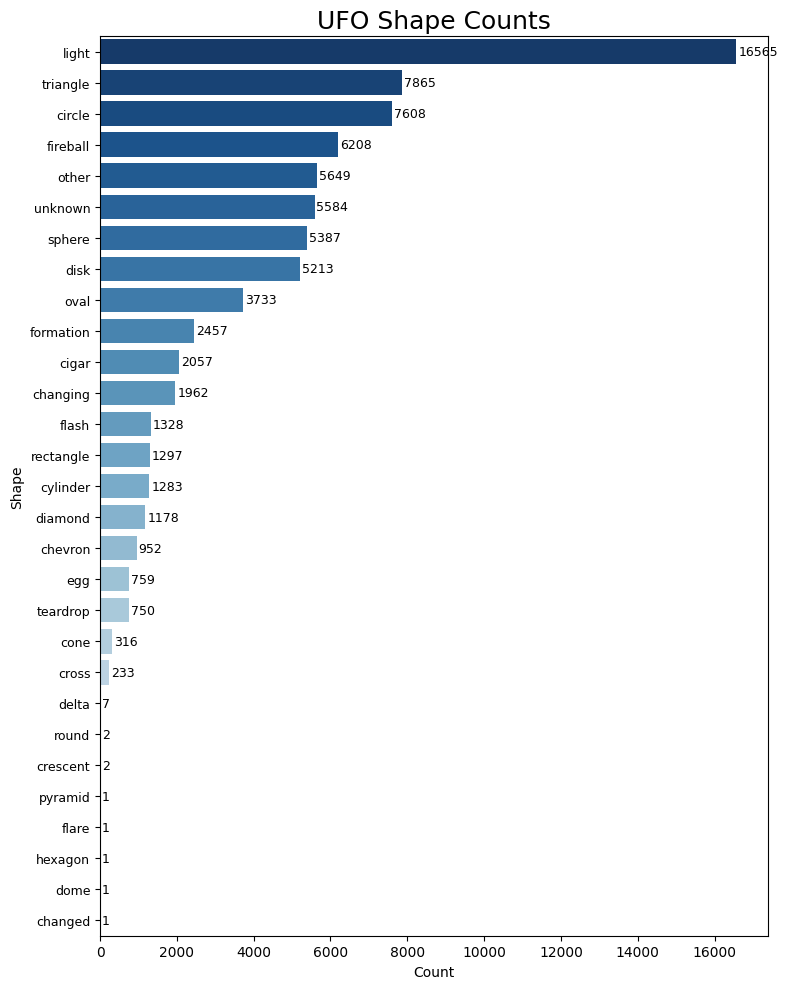

In [10]:
shape_counts = ufo_df['shape'].value_counts()

plt.figure(figsize=(8, 10))
ax = sns.barplot(
    x=shape_counts.values,
    y=shape_counts.index,
    hue=shape_counts.index,
    palette="Blues_r"
)
plt.title("UFO Shape Counts", fontsize=18)
plt.xlabel("Count")
plt.ylabel("Shape")
plt.yticks(fontsize=9)
for i, v in enumerate(shape_counts.values):
    ax.text(v + 50, i, str(v), va='center', fontsize=9)
plt.tight_layout()
plt.show()

In [11]:
shape_counts = ufo_df['shape'].value_counts()
rare_shapes = shape_counts[shape_counts < 200].index
ufo_df['shape'] = ufo_df['shape'].replace(rare_shapes, 'other')

In [12]:
ufo_cleaned = ufo_df.copy()

#### Drop Unused Columns

In [13]:
# Drop unused columns
ufo_cleaned = ufo_cleaned.drop(columns=["comments", "date posted","duration (hours/min)"])

The `duration (hours/min)` column was dropped because it duplicates the information in duration (seconds) but in inconsistent units. Keeping only the numeric duration simplifies analysis and ensures accurate quantitative modeling.

The `comments` column was removed since it contains unstructured text outside the scope of this study, which focuses on numerical and spatial patterns rather than linguistic content.

The `date posted` column was excluded because it reflects when a report was submitted, not when the sighting occurred. The true event timing is already captured in the `datetime` field, making date posted less meaningful for UFO pattern analysis.

### `datetime` Processing

#### Convert `datetime` to Datetime type

Converting the datetime column to datetime format ensures consistent and accurate time-based analysis and operations across the dataset.

We found that some records in `datetime` contained timestamps using "24:00", which is invalid in Python's datetime format. The value "24:00" represents midnight of the following day, but since most libraries only accept hours from 00 to 23, these entries caused conversion errors. To handle this, all "24:00" values were replaced with "00:00"

In [14]:
ufo_cleaned["datetime"] = (ufo_cleaned["datetime"].astype(str).apply(lambda x: re.sub(r"24:00", "00:00", x)))
ufo_cleaned["datetime"] = pd.to_datetime(ufo_cleaned["datetime"])

This small adjustment preserves the temporal meaning of the records while ensuring compatibility with pandas datetime operations.

### Clean `duration (seconds)` Text and Convert to Numerical

In [15]:
dur_str = (ufo_cleaned['duration (seconds)'].astype(str).str.replace(',', '.', regex=False) )
# Extract the first numeric pattern
ufo_cleaned['duration (seconds)'] = dur_str.str.extract(r'(\d*\.?\d+)')[0]
# Convert to float
ufo_cleaned['duration (seconds)'] = pd.to_numeric(ufo_cleaned['duration (seconds)'])

### Standardize `latitude` and `longitude`

In [16]:
def extract_numeric(value):
    """
    Extracts the first valid float-like number (with optional minus sign and decimal)
    from a string. Returns NaN if no valid number found.
    """
    if pd.isna(value):
        return None
    match = re.search(r"-?\d+\.?\d*", str(value))
    if match:
        return float(match.group())
    return None

In [17]:
ufo_cleaned["latitude"] = ufo_cleaned["latitude"].apply(extract_numeric)
ufo_cleaned["longitude"] = ufo_cleaned["longitude"].apply(extract_numeric)
# Convert to numeric just in case and drop invalid rows
ufo_cleaned["latitude"] = pd.to_numeric(ufo_cleaned["latitude"], errors="coerce")
ufo_cleaned["longitude"] = pd.to_numeric(ufo_cleaned["longitude"], errors="coerce")

To ensure all coordinate information was standardized for downstream geospatial analysis, I implemented a custom cleaning pipeline using a regex-based function:*extract_numeric* to extract valid float-like numbers from potentially messy latitude and longitude entries. This approach handled irregular formats (e.g., values containing symbols, extra spaces, or text) and safely converted all coordinates to numeric types. After cleaning, both latitude and longitude columns contained 78,400 valid float64 values, confirming that all coordinate data were successfully retained and standardized.

### Standardize `city`, `state`, and `country`

In [18]:
# Extract coordinates
coords = list(zip(ufo_cleaned["latitude"], ufo_cleaned["longitude"]))
# Batch reverse-geocode
results = rg.search(coords)
# Create geocoded DataFrame and align
geo_df = pd.DataFrame(results)
geo_df.index = ufo_cleaned.index
# Replace state & country with standardized values
ufo_cleaned["city"] = geo_df["name"]
ufo_cleaned["state"] = geo_df["admin1"]
ufo_cleaned["country"] = geo_df["cc"]

Loading formatted geocoded file...


We regenerated the `city`, `state`, and `country` columns directly from the latitude and longitude coordinates to achieve a consistent and standardized geographic representation across all records. The original text-based fields contained irregularities such as inconsistent capitalization, abbreviations, and mixed naming conventions, which made them unreliable for quantitative analysis or model training. In contrast, latitude and longitude are precise and continuous numerical values that can be used to objectively infer standardized location information through reverse geocoding. This ensures that entries with identical coordinates map to the same administrative regions, eliminating human errors and variations in naming.


In [19]:
ufo_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78400 entries, 0 to 80331
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            78400 non-null  datetime64[ns]
 1   city                78400 non-null  object        
 2   state               78400 non-null  object        
 3   country             78400 non-null  object        
 4   shape               78400 non-null  object        
 5   duration (seconds)  78400 non-null  float64       
 6   latitude            78400 non-null  float64       
 7   longitude           78400 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 5.4+ MB


## City Features Dataset

We include this dataset to provide additional environmental and geographic context for each reported UFO sighting.
This dataset was obtained from publicly available resources, including the SimpleMaps World Cities database, NASA/NOAA VIIRS nighttime lights data, and climate/elevation data provided by WorldClim.

In [20]:
city_github_url = 'https://raw.githubusercontent.com/jingyig16/ufo-sightings/refs/heads/main/new_dataset/city_features.csv'
city_df = pd.read_csv(city_github_url, low_memory=False)

In [21]:
city_df.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id,wc_bio1,wc_bio4,wc_bio12,elevation_m,viirs_annual_ave
0,Tokyo,Tokyo,35.6870,139.7495,Japan,JP,JPN,Tōkyō,primary,37785000.0,1392685764,15.704166,769.836060,1431.0,33.0,28.124304
1,Jakarta,Jakarta,-6.1750,106.8275,Indonesia,ID,IDN,Jakarta,primary,33756000.0,1360771077,27.700001,37.598354,1958.0,6.0,32.622326
2,Delhi,Delhi,28.6100,77.2300,India,IN,IND,Delhi,admin,32226000.0,1356872604,25.170834,684.120056,730.0,214.0,67.107742
3,Guangzhou,Guangzhou,23.1300,113.2600,China,CN,CHN,Guangdong,admin,26940000.0,1156237133,22.320833,571.980041,1729.0,21.0,53.230152
4,Mumbai,Mumbai,19.0761,72.8775,India,IN,IND,Mahārāshtra,admin,24973000.0,1356226629,27.691668,182.356216,2159.0,6.0,37.921257


In [22]:
len(city_df)

48059

In [23]:
city_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48059 entries, 0 to 48058
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   city              48059 non-null  object 
 1   city_ascii        48057 non-null  object 
 2   lat               48059 non-null  float64
 3   lng               48059 non-null  float64
 4   country           48059 non-null  object 
 5   iso2              48026 non-null  object 
 6   iso3              48059 non-null  object 
 7   admin_name        47858 non-null  object 
 8   capital           15138 non-null  object 
 9   population        47808 non-null  float64
 10  id                48059 non-null  int64  
 11  wc_bio1           47484 non-null  float64
 12  wc_bio4           47484 non-null  float64
 13  wc_bio12          47484 non-null  float64
 14  elevation_m       47484 non-null  float64
 15  viirs_annual_ave  48055 non-null  float64
dtypes: float64(8), int64(1), object(7)
memor

In [24]:
city_df=city_df.rename(columns={
    "wc_bio1":"avg_annual_temp(°C)",
    "wc_bio4":"temp_seasonality",
    "wc_bio12":"annual_precipitation(mm)",
    "elevation_m":"elevation(m)"
})

- `lat / lng` – City coordinates to map sightings.
- `population` – Size of the city, used to estimate human activity.
- `avg_annual_temp(°C)` – Average yearly temperature, representing climate conditions.
- `temp_seasonality` – How much temperature changes throughout the year.
- `annual_precipitation(mm)` – Total rainfall, another environmental factor.
- `elevation(m)` – City height above sea level.
- `viirs_annual_ave` – Nighttime light intensity, a proxy for visibility and urbanization.








In [25]:
city_cleaned = city_df.copy()

### Drop Unused Columns

In [26]:
city_cleaned = city_cleaned.drop(['city_ascii','iso2', 'iso3', 'admin_name', 'id', 'capital'], axis=1)

The `city_ascii` column was removed because the geographic position of each observation is already precisely defined by its latitude and longitude coordinates, and we will do standardization of city names.

The `iso2`and `iso3` columns were dropped because country information is already represented by the `country` field, while geographic location is fully captured by the `lat` and `lng` coordinates. Retaining multiple identifiers for the same attribute would introduce redundancy without adding analytical value.

The `admin_name`, `id` and `capital` columns were dropped because they contain administrative or metadata fields inherited from the original city dataset (e.g., province names, city IDs, or capital status) that are not relevant to the spatial analysis or the merging process with the UFO dataset. They were excluded to streamline the dataset and maintain focus on features directly related to location matching.

In [27]:
city_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48059 entries, 0 to 48058
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   city                      48059 non-null  object 
 1   lat                       48059 non-null  float64
 2   lng                       48059 non-null  float64
 3   country                   48059 non-null  object 
 4   population                47808 non-null  float64
 5   avg_annual_temp(°C)       47484 non-null  float64
 6   temp_seasonality          47484 non-null  float64
 7   annual_precipitation(mm)  47484 non-null  float64
 8   elevation(m)              47484 non-null  float64
 9   viirs_annual_ave          48055 non-null  float64
dtypes: float64(8), object(2)
memory usage: 3.7+ MB


### Standardize `latitude` and `longitude`



In [28]:
city_cleaned["lat"] = city_cleaned["lat"].apply(extract_numeric)
city_cleaned["lng"] = city_cleaned["lng"].apply(extract_numeric)

city_cleaned["lat"] = pd.to_numeric(city_cleaned["lat"])
city_cleaned["lng"] = pd.to_numeric(city_cleaned["lng"])

### Standardize `city`, `state`, and `country`

In [29]:
# Extract coordinates
coords = list(zip(city_cleaned["lat"], city_cleaned["lng"]))
# Batch reverse-geocode
results = rg.search(coords)
# Create geocoded DataFrame and align
geo_df = pd.DataFrame(results)
geo_df.index = city_cleaned.index
# Replace state & country with standardized values
city_cleaned["city"] = geo_df["name"]
city_cleaned["state"] = geo_df["admin1"]
city_cleaned["country"] = geo_df["cc"]

Use the same method as how we processed `city`, `state` and `country` names in `ufo_cleaned` to ensure consistency.

## Global Airports Dataset

This dataset is obtained from OurAirports, an open data platform that provides up-to-date global airport information for public use.




We include the Global Airports dataset to account for aviation activity that may influence UFO reports. Airports generate frequent aircraft traffic and night-time lighting, both of which are known sources of UFO misidentification. By incorporating accurate airport locations, we can measure each sighting's proximity to aviation infrastructure and control for these human-error factors in our analysis.

In [30]:
global_airports_github_url = 'https://raw.githubusercontent.com/jingyig16/ufo-sightings/refs/heads/main/new_dataset/world-airports.csv'
airports_df = pd.read_csv(global_airports_github_url, low_memory=False)

In [31]:
airports_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84109 entries, 0 to 84108
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 84109 non-null  int64  
 1   ident              84109 non-null  object 
 2   type               84109 non-null  object 
 3   name               84109 non-null  object 
 4   latitude_deg       84109 non-null  float64
 5   longitude_deg      84109 non-null  float64
 6   elevation_ft       69531 non-null  float64
 7   continent          44759 non-null  object 
 8   country_name       84109 non-null  object 
 9   iso_country        83841 non-null  object 
 10  region_name        84109 non-null  object 
 11  iso_region         84109 non-null  object 
 12  local_region       84092 non-null  object 
 13  municipality       79360 non-null  object 
 14  scheduled_service  84109 non-null  int64  
 15  gps_code           43697 non-null  object 
 16  icao_code          931

In [32]:
airports_df['type'].unique()

array(['large_airport', 'closed', 'medium_airport', 'small_airport',
       'seaplane_base', 'heliport', 'balloonport'], dtype=object)

In [33]:
irrelavant_types = ["balloonport", "seaplane_base","closed"]
airports_df=airports_df[~airports_df['type'].isin(irrelavant_types)]
airports_df=airports_df.drop(columns=['type'])

We removed the categories “balloonport, “seaplane_base,” and “closed” because they do not contribute meaningful aviation activity that could influence UFO sightings. Balloonports and seaplane bases operate primarily during daytime and produce minimal lighting or flight traffic. This means they are unlikely to cause people to confuse normal aircraft with UFOs, so they do not add useful information to our analysis.

In [34]:
airports_df=airports_df[['name','latitude_deg','longitude_deg']]

In [35]:
airports_df.head(5)

,name,latitude_deg,longitude_deg
0,London Heathrow Airport,51.470600,-0.461941
1,Los Angeles International Airport,33.942501,-118.407997
2,Chicago O'Hare International Airport,41.978600,-87.904800
3,John F Kennedy International Airport,40.639447,-73.779317
4,Hartsfield Jackson Atlanta International Airport,33.636700,-84.428101


## Country Education Level Dataset

This dataset is obtained from the Our World in Data (OWID) education statistics, made publicly available through a Kaggle dataset.


In [36]:
edu_github_url = 'https://raw.githubusercontent.com/jingyig16/ufo-sightings/refs/heads/main/new_dataset/global_education_modified.csv'
edu_df = pd.read_csv(edu_github_url,low_memory=False)

To capture the cultural and socioeconomic context behind how UFO sightings are interpreted and reported, we include two national-level indicators: `Gross_Tertiary_Education_Enrollment` and `Unemployment_Rate`. Prior work on UFO reporting and anomalous perception suggests that the way people describe unusual aerial phenomena, including the shape they report, is strongly influenced by cultural background, scientific literacy, and social conditions. Higher educational attainment and literacy reflect exposure to scientific reasoning and familiarity with aviation, astronomy, and satellite activity, which may shape how observers interpret ambiguous lights or objects. Meanwhile, unemployment rate serves as a proxy for broader socioeconomic conditions that may affect outdoor activity patterns, attention to the night sky, and even reporting behavior. By including this small set of culturally meaningful features, we aim to capture human-contextual factors that may influence how UFO shapes are perceived and documented.

In [37]:
edu_df.columns = edu_df.columns.str.strip()

In [38]:
edu_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 31 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Countries and areas                      202 non-null    object 
 1   Latitude                                 189 non-null    float64
 2   Longitude                                189 non-null    float64
 3   OOSR_Pre0Primary_Age_Male                202 non-null    int64  
 4   OOSR_Pre0Primary_Age_Female              202 non-null    int64  
 5   OOSR_Primary_Age_Male                    202 non-null    int64  
 6   OOSR_Primary_Age_Female                  202 non-null    int64  
 7   OOSR_Lower_Secondary_Age_Male            202 non-null    int64  
 8   OOSR_Lower_Secondary_Age_Female          202 non-null    int64  
 9   OOSR_Upper_Secondary_Age_Male            202 non-null    int64  
 10  OOSR_Upper_Secondary_Age_Female          202 non-n

In [39]:
edu_df = edu_df[['Latitude','Longitude','Gross_Tertiary_Education_Enrollment','Unemployment_Rate']].copy()
edu_df=edu_df.dropna()

## Entity Linking

### City Features with UFO Sighting

In the city features dataset, `population`, `avg_annual_temp(°C)`, `temp_seasonality`, `annual_precipitation(mm)`, `elevation(m)`, and `viirs_annual_ave` contain missing values for some cities. If we simply merged each UFO sighting with the single nearest city, some UFO records would inherit missing feature values even though a slightly more distant nearby city has complete data.

To address this, we implemented a nearest–non-null matching procedure:

- For each UFO sighting, we identified the k nearest cities using BallTree K-nearest-neighbor search in projected coordinates.

- For each feature, we examined these candidate cities in order of distance (nearest → farther).

- We selected the closest city that actually has a valid (non-null) value for that feature.

- We also recorded the distance to the city that supplied the data, producing a meaningful measure of spatial accuracy.

This approach preserves geographic proximity while ensuring that we do not propagate missing values. It produces feature assignments that are both spatially reasonable (always taking the closest available city) and data-complete (never selecting a city with missing information if a slightly farther city has valid data). The resulting dataset is therefore more robust for downstream modeling and analysis.

In [40]:
def ufo_with_city_features(g_ufo_m, g_cities_m, features_to_match, k=5):
    """
    Find the closest city (within k candidates) that has non-null values for each feature
    and compute the distance to the specific fallback city used for that feature.
    """
    # Extract (x, y) coordinates for KNN search
    city_coords = np.vstack([g_cities_m.geometry.x, g_cities_m.geometry.y]).T
    ufo_coords  = np.vstack([g_ufo_m.geometry.x, g_ufo_m.geometry.y]).T
    # Build a BallTree from city coordinates
    tree = BallTree(city_coords)
    # Query k nearest cities for each UFO point
    # dists[i, j] = distance from UFO i to its j-th nearest city
    # idxs[i, j]  = row index in g_cities_m of that j-th nearest city
    dists, idxs = tree.query(ufo_coords, k=k)

    result = g_ufo_m.copy()

    feature_dist_cols = []  #To store temporary distance columns here (one per feature).
    # Find fallback for each feature
    for col in features_to_match:
        chosen_vals = []
        chosen_dists = []

        for u in range(len(idxs)):
            candidates = idxs[u]       # k nearest city indices
            distances = dists[u]       # the distances from u-th UFO to each of the k cities.
            found = False
            for rank, city_idx in enumerate(candidates):
                val = g_cities_m.iloc[city_idx][col]
                if pd.notnull(val):
                    chosen_vals.append(val)               # record fallback feature values
                    chosen_dists.append(distances[rank])  # record fallback distance
                    found = True
                    break
            if not found:
                chosen_vals.append(np.nan)
                chosen_dists.append(np.nan)
        # Write chosen values to result
        result[col] = chosen_vals
        # Store distance column temporarily
        dist_col_name = f"__dist_{col}"
        result[dist_col_name] = chosen_dists
        feature_dist_cols.append(dist_col_name)

    # final dist_m: max distance across all fallback distances for this UFO record
    result["dist_m"] = result[feature_dist_cols].max(axis=1)
    # Remove temporary per-feature dist columns
    result = result.drop(columns=feature_dist_cols)

    return result

In [41]:
# A GeoDataFrame is like a normal DataFrame but supports spatial operations.
# geometry=gpd.points_from_xy(...): Converts each (longitude, latitude) pair into a Point geometry object since GeoPandas requires a geometry column to do spatial joins.
# crs="EPSG:4326": Sets the coordinate reference system (CRS) to the standard GPS coordinates(EPSG:4326)
g_ufo   = gpd.GeoDataFrame(ufo_cleaned, geometry=gpd.points_from_xy(ufo_cleaned.longitude, ufo_cleaned.latitude), crs="EPSG:4326")
g_cities= gpd.GeoDataFrame(city_cleaned, geometry=gpd.points_from_xy(city_cleaned.lng, city_cleaned.lat), crs="EPSG:4326")
# EPSG 3857 is a metric projection, meaning its units are meters.
g_ufo_m    = g_ufo.to_crs(3857)
g_cities_m = g_cities.to_crs(3857)

In [42]:
features_to_match= [
    "population",
    "avg_annual_temp(°C)",
    "temp_seasonality",
    "annual_precipitation(mm)",
    "elevation(m)",
    "viirs_annual_ave"
]
joined = ufo_with_city_features(g_ufo_m, g_cities_m, features_to_match, k=5)

#### Processing the joined dataframe

We want to attach city-level climate and environmental information (like temperature, precipitation, elevation, and nighttime light) to each UFO sighting.
Since these climate variables are measured at the city level, which represents a fairly large surrounding area, we assume that a city's climate represents the conditions within 100 km around that (latitude,longitude).
Based on this assumption, we link each UFO sighting to the nearest city, but only if it is within 100 km.
This way, the environmental information we attach to each sighting is accurate and geographically relevant.

In [43]:
# Filter out far matches > 100 km)
joined = joined[joined['dist_m'] <= 100000]
joined = joined.drop(columns=['dist_m'])

We drop the `geometry` column because it is only required by GeoPandas for spatial operations, and once the spatial matching is complete, the geometry objects are no longer needed.

In [44]:
joined = joined.drop(columns=['geometry'])

### Country Education Level with UFO Sighting

In [45]:
edu_df["Latitude"] = edu_df["Latitude"].apply(extract_numeric)
edu_df["Longitude"] = edu_df["Longitude"].apply(extract_numeric)

edu_df["Latitude"] = pd.to_numeric(edu_df["Latitude"])
edu_df["Longitude"] = pd.to_numeric(edu_df["Longitude"])

edu_df=edu_df.dropna(subset=['Latitude','Longitude'])

In [46]:
# Extract coordinates
coords = list(zip(edu_df["Latitude"], edu_df["Longitude"]))
# Batch reverse-geocode
results = rg.search(coords)
# Create geocoded DataFrame and align
geo_df = pd.DataFrame(results)
geo_df.index = edu_df.index
# Replace state & country with standardized values
edu_df["country"] = geo_df["cc"]

In [47]:
joined = joined.merge(edu_df,on="country",how="inner")

In [48]:
joined=joined.drop(columns=['Latitude','Longitude'])

## Feature Engineering - Create Related New Features

### A New Categorical Feature: `time_of_day`


To make the time information more meaningful for our analysis, we extracted the hour from the original timestamp and grouped it into a new categorical feature, `time_of_day`. Using exact hour values (e.g., 13 vs. 14) may introduce unnecessary noise because such small differences in time rarely change UFO visibility in a meaningful way. By converting the 24-hour numeric scale into broader, real-world lighting conditions, such as Dawn, Day, Dusk, and Night, we enable the model to learn more informative patterns related to when sightings are most likely to occur. This transformation not only simplifies the feature space and prevents sparsity but also improves interpretability, making it easier to understand and communicate results (for example, if night sightings are noticeably more common). Ultimately, this categorization highlights useful temporal trends that might otherwise be hidden in raw hourly data.

In [49]:
joined["hour"] = joined["datetime"].dt.hour

Then categorize that hour into human-interpretable groups:

Dawn (6-8 AM)

Day (9 AM-4 PM)

Dusk (4-7 PM)

Night (8 PM-5 AM)

In [50]:
def categorize_time_of_day(hour):
        if 6 <= hour < 9:
            return 'Dawn'
        elif 9 <= hour < 16:
            return 'Day'
        elif 16 <= hour < 19:
            return 'Dusk'
        else:
            return 'Night'

In [51]:
joined["time_of_day"] = joined["hour"].apply(categorize_time_of_day)
joined=joined.drop(columns=['hour'])

### A New Numerical feature:` dist_to_nearest_airport(m) `


To quantify how close each UFO sighting occurred to major airports, we calculated the distance from every sighting to its nearest airport using airport latitude/longitude data. We built a BallTree with the haversine metric to correctly compute great-circle distances on Earth and identified the closest airport for each UFO point. The resulting feature, `dist_to_nearest_airport(m)`, indicates how near the sighting was to an airport, helping us evaluate whether airport lighting or aircraft operations might contribute to some reports.


In [52]:
airport_coords = np.vstack([airports_df["longitude_deg"].values,airports_df["latitude_deg"].values]).T
ufo_coords = np.vstack([joined["longitude"].values,joined["latitude"].values]).T
# Convert degrees → radians for haversine
airport_rad = np.radians(airport_coords)
ufo_rad = np.radians(ufo_coords)
# Build BallTree for nearest-neighbor search
tree = BallTree(airport_rad, metric='haversine')
# Query nearest airport record for each UFO sighting
dists_rad, idxs = tree.query(ufo_rad, k=1)
earth_radius_m = 6371000  # meters
# Calculate the distance
dists_m = dists_rad[:, 0] * earth_radius_m
joined["dist_to_nearest_airport(m)"] = dists_m

In [53]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76441 entries, 0 to 76440
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   datetime                             76441 non-null  datetime64[ns]
 1   city                                 76441 non-null  object        
 2   state                                76441 non-null  object        
 3   country                              76441 non-null  object        
 4   shape                                76441 non-null  object        
 5   duration (seconds)                   76441 non-null  float64       
 6   latitude                             76441 non-null  float64       
 7   longitude                            76441 non-null  float64       
 8   population                           76441 non-null  float64       
 9   avg_annual_temp(°C)                  76441 non-null  float64       
 10  temp_seaso

# Part 3: Exploratory Data Analysis


## 3.1 Country-Level Shape Distributions

To examine whether country-level features carry predictive value for UFO shape classification, we begin by analyzing how reported shapes vary **across countries**.

### 3.1.1 UFO Sighting Frequency across Countries

As a first step, we examine the geographic distribution of UFO sighting frequency. Understanding where reports are concentrated is essential, because cross-country differences in reporting activity may reflect underlying social or environmental conditions that also affect the types of shapes people describe. Establishing this baseline helps contextualize later analyses of shape distributions and ensures that any observed shape patterns are interpreted in light of the underlying reporting landscape.


In [54]:
# Assign a weight of 1 to every sighting
plot_df = joined.copy()
plot_df["intensity"] = 1
heat_data = plot_df[["latitude", "longitude", "intensity"]].values.tolist()

# Custom bright heatmap color gradient
custom_gradient = {0.0: "#0000FF",0.4: "#00FFFF",0.6: "#00FF00",0.8: "#FFFF00",1.0: "#FF0000",   }

# Create a bounded world map
m = folium.Map(location=[20, 0],zoom_start=2,min_zoom=2,max_bounds=True,tiles="CartoDB dark_matter",
               width="85%",height="85%",control_scale=False)
# Add the heatmap layer
HeatMap(heat_data,radius=18,blur=12,min_opacity=0.3,max_zoom=4,gradient=custom_gradient).add_to(m)

# Display the map
m

The global heatmap of UFO sighting frequency shows clear geographic differences. North America and parts of Europe report many more sightings, while large areas of Africa and South America report very few. These differences likely reflect country-level factors that affect how often people submit reports, such as education level, literacy, internet access, and the strength of online reporting systems. Countries with better access to information and communication tools may contribute more sightings to databases like NUFORC, regardless of the true underlying rate of unusual events.

This pattern is important for modeling because it shows that country-level features influence not only where sightings occur but also how likely they are to be reported. These social and geographic factors may also affect how people interpret and describe what they see. As a result, such features may provide useful predictive signal for UFO shape classification and help us better understand differences in reporting behavior across countries.

### 3.1.2 Most Frequently Reported Countries

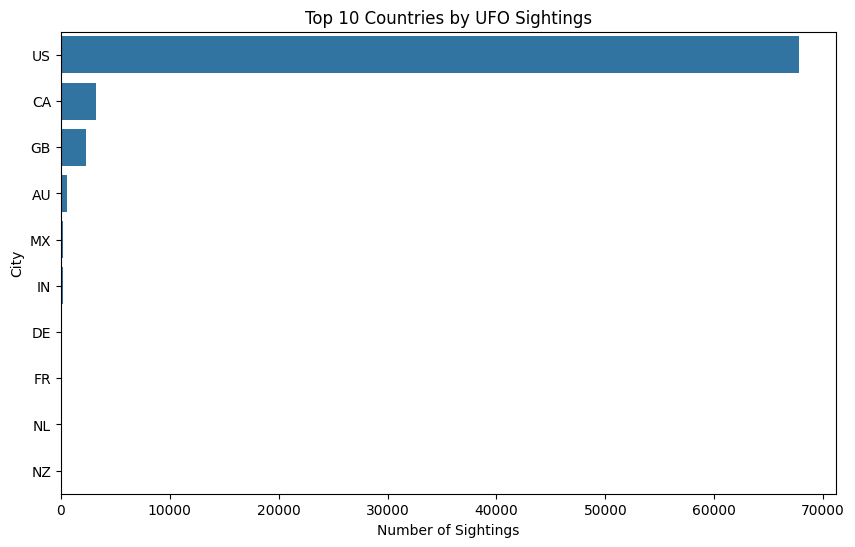

In [55]:
country_counts = joined.groupby("country").size().reset_index(name="sightings").sort_values("sightings", ascending=False)

# Plot top 10 countries
plt.figure(figsize=(10, 6))
sns.barplot(data=country_counts.head(10),
    x="sightings", y="country")
plt.title("Top 10 Countries by UFO Sightings")
plt.xlabel("Number of Sightings")
plt.ylabel("City")
plt.show()

Across all countries, the United States reports an overwhelmingly larger number of sightings than any other country, with totals near 70,000. This far exceeds the next-closest countries and creates a distribution dominated almost entirely by US observations. This likely reflects differences in reporting culture, the long-standing presence of UFO-related media or imbalance from data collection in the US rather than a true difference in underlying phenomena.

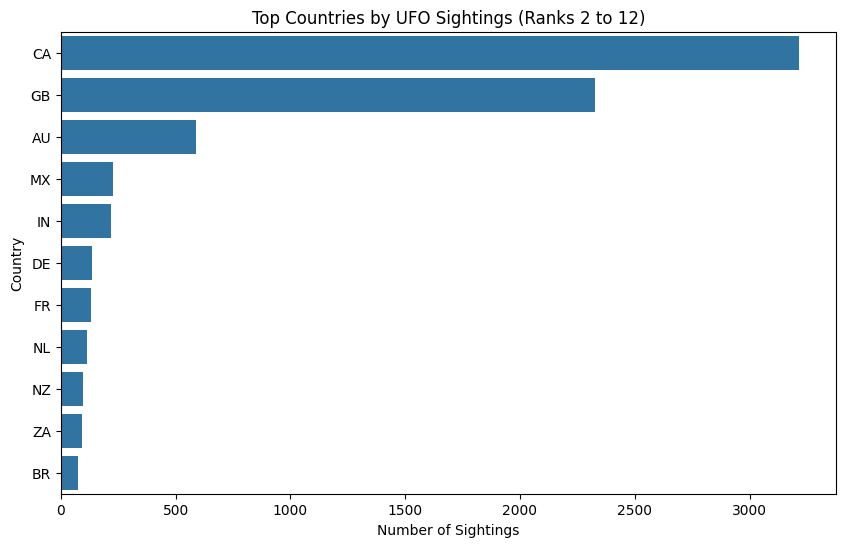

In [56]:
subset = country_counts.iloc[1:12]   # rows 1 to 11 inclusive

plt.figure(figsize=(10, 6))
sns.barplot(data=subset, x="sightings", y="country")
plt.title("Top Countries by UFO Sightings (Ranks 2 to 12)")
plt.xlabel("Number of Sightings")
plt.ylabel("Country")
plt.show()


When the US is removed from the ranking, Canada and the United Kingdom account for the next largest volumes of sightings, but still at only a fraction of US levels. After these two countries, the counts drop off sharply, indicating that most nations have limited or inconsistent reporting infrastructure. This pattern suggests that any global modeling effort must correct for reporting biases before drawing scientific conclusions.

### 3.1.3 UFO Shape Distributions within each Country

The global distribution of sighting counts indicates that reporting frequency is strongly shaped by country-specific factors. If these factors influence whether a sighting is reported, they may also influence how it is reported. To test this idea, we turn to the normalized distribution of UFO shapes across countries.

In [57]:
# Count sightings per shape per country
df_counts = (joined.groupby(['country', 'shape']).size().reset_index(name='count'))

# Normalize within each country
totals = df_counts.groupby('country')['count'].sum().reset_index(name='total')
df_norm = df_counts.merge(totals, on='country')
df_norm['pct'] = df_norm['count'] / df_norm['total']

# Pivot to matrix
heatmap_df = df_norm.pivot(index='country',columns='shape',values='pct').fillna(0)

# Plot
fig = px.imshow(heatmap_df, color_continuous_scale="Viridis",aspect="auto",height=1000,width=800,
                title="UFO Shape Distribution Across 158 Countries (Normalized)")

fig.update_layout(xaxis_title="UFO Shape",yaxis_title="Country",)
fig.show()


This heatmap shows the normalized distribution of UFO shapes across 158 countries.
- Each row = country
- Each column = UFO shape
- Each cell = percentage of that shape within that country's sightings

Because each row is normalized, bright (yellow) cells indicate a shape that is unusually dominant within that country.

The heatmap shows clear cross-country variance in the distribution of UFO shapes.
Since different countries exhibit different dominant shapes,
this indicates that country-level features carry useful information about the expected UFO shape.


## 3.2 City-Level Feature Relationships within North America

In [58]:
# Filter North America: US, Canada, Mexico
na_countries = ["US", "CA", "MX"]
na_df = joined[joined["country"].isin(na_countries)].copy()

na_df.shape

(71213, 18)

### 3.2.1 Most Frequently Reported Cities

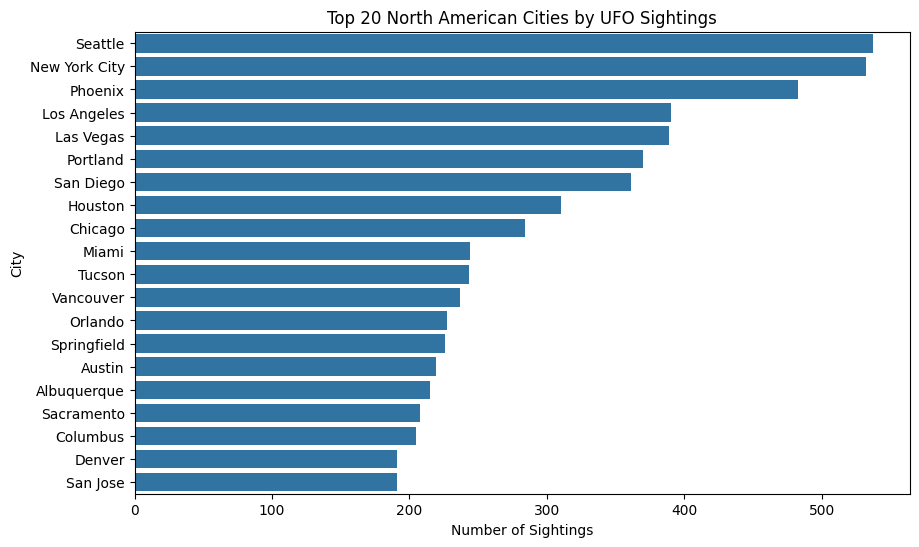

In [59]:
city_counts = na_df.groupby("city").size().reset_index(name="sightings").sort_values("sightings", ascending=False)

# Plot top 20 cities
plt.figure(figsize=(10, 6))
sns.barplot(data=city_counts.head(20),
    x="sightings", y="city")
plt.title("Top 20 North American Cities by UFO Sightings")
plt.xlabel("Number of Sightings")
plt.ylabel("City")
plt.show()

Within North America, a handful of major metropolitan areas generate a disproportionate number of UFO reports. Cities such as Seattle, New York City, and Phoenix stand out as clear hotspots, with each recording several hundred sightings. Many other large cities appear in the ranking as well, which implies that urban environments offer more opportunities for observation and reporting.

Interestingly, these high-ranking cities span different regions and climates, which reduces the likelihood that a single environmental factor explains the concentration. Instead, the pattern suggests that population density, visibility conditions, and local engagement with UFO culture jointly shape reporting behavior.

In [60]:
top5_shapes = (
    na_df["shape"]
        .value_counts()
        .head(5)
        .index
)


In [61]:
shape_city_counts = (
    na_df[na_df["shape"].isin(top5_shapes)]
        .groupby(["shape", "city"])
        .size()
        .reset_index(name="sightings")
)


/tmp/ipython-input-1815219962.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



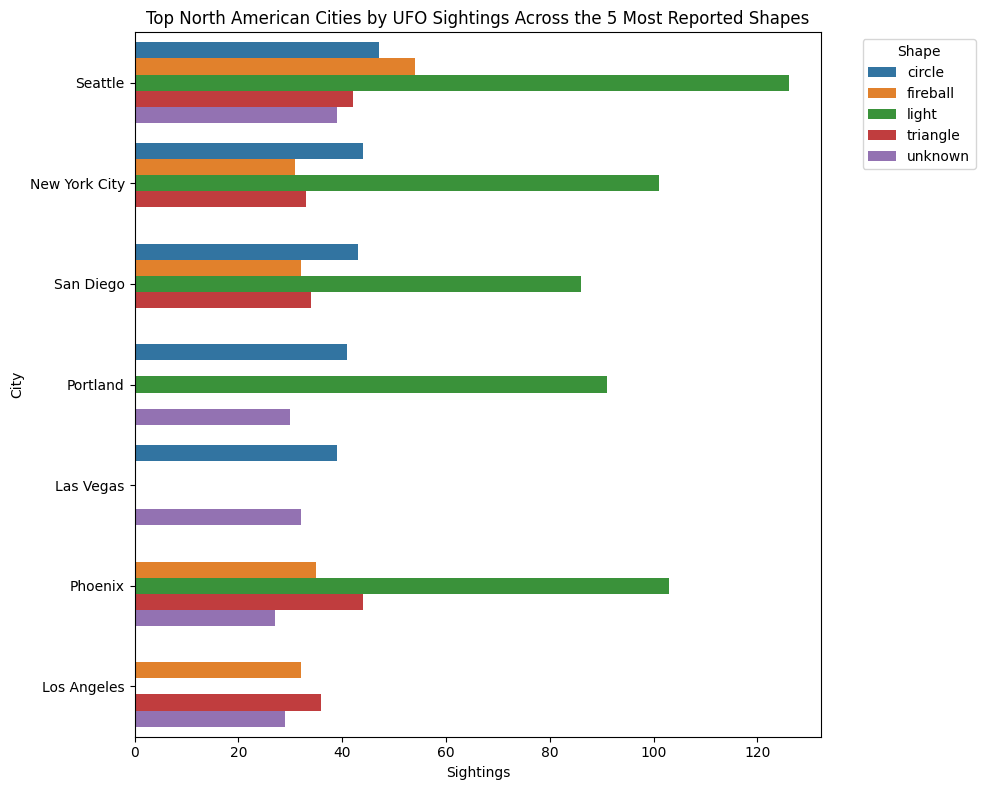

In [62]:
top_cities_per_shape = (
    shape_city_counts.groupby("shape")
        .apply(lambda x: x.sort_values("sightings", ascending=False).head(5))
        .reset_index(drop=True)
)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_cities_per_shape,
    x="sightings",
    y="city",
    hue="shape"
)

plt.title("Top North American Cities by UFO Sightings Across the 5 Most Reported Shapes")
plt.xlabel("Sightings")
plt.ylabel("City")
plt.legend(title="Shape", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


TODO: Interpretation

- Deleted Urbanization, population vs # of sightings
- Added cities by shape

## 3.3 Distance to Airport EDA

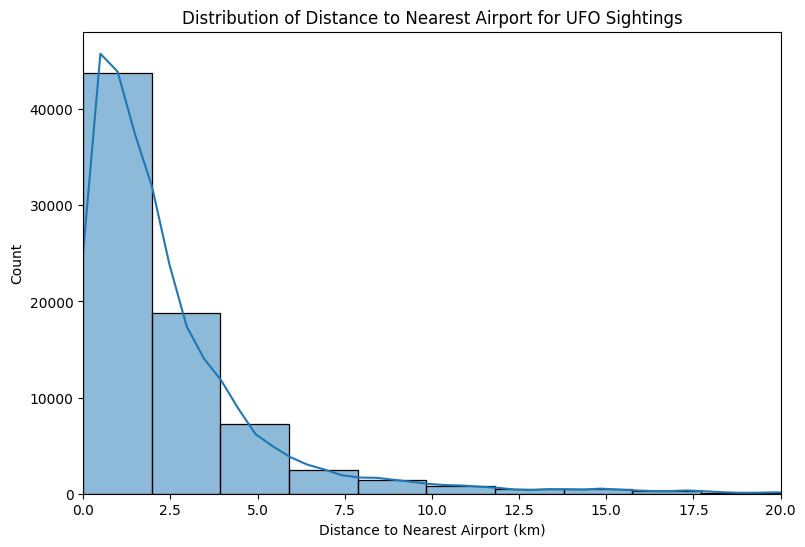

In [63]:
plt.figure(figsize=(9,6))
sns.histplot(joined["dist_to_nearest_airport(m)"]/1000, bins=50, kde=True)
plt.xlim(0, 20)
plt.xlabel("Distance to Nearest Airport (km)")
plt.ylabel("Count")
plt.title("Distribution of Distance to Nearest Airport for UFO Sightings")
plt.show()


The distribution of distances between UFO sightings and their nearest airports reveals a clear concentration of reports occurring very close to airports. A large majority of sightings fall within roughly 2.5 km, and the frequency drops sharply as distance increases. This pattern suggests that proximity to airports may play an important role in how often people perceive and report unidentified objects.

One plausible explanation is that aircraft activity near airports increases the likelihood of misinterpretation. Lights, reflections, landing patterns, and sudden directional changes can all appear unusual to observers on the ground, especially at night. As a result, areas immediately surrounding airports may naturally produce more reports that are later categorized as UFO sightings even though they may be airplanes.

## 3.4 Time-based pattern

In [64]:
def prepare_temporal_features(df):
    """Extract temporal features from datetime column"""
    df = df.copy()
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['decade'] = (df['year'] // 10) * 10
    df['season'] = df['month'].apply(lambda x: 'Winter' if x in [12, 1, 2]
                                               else 'Spring' if x in [3, 4, 5]
                                               else 'Summer' if x in [6, 7, 8]
                                               else 'Fall')
    return df

In [65]:
# Apply temporal feature extraction
joined_temporal = prepare_temporal_features(joined)


### 3.4.1 Reporting Patterns Over Time Across Whole Dataset

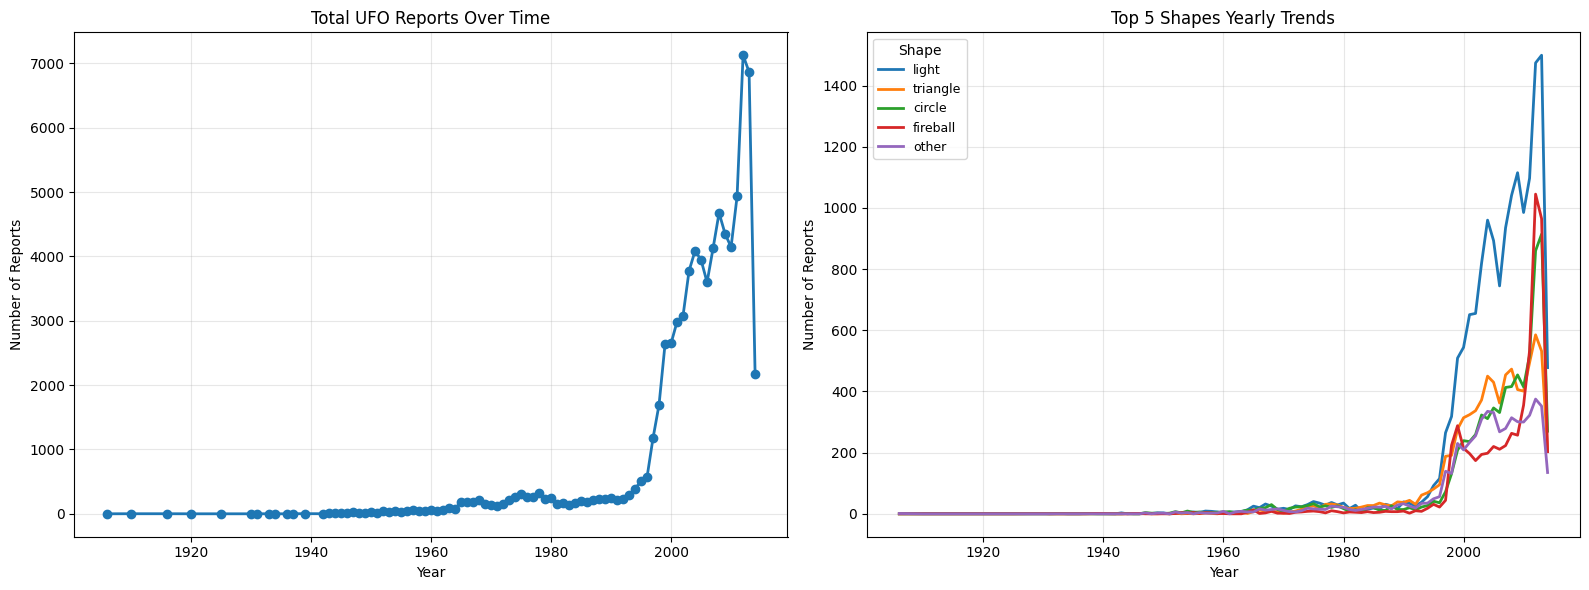

In [66]:
yearly_total = joined_temporal.groupby("year").size()

# Reports per (year, shape)
yearly_shape = joined_temporal.groupby(["year", "shape"]).size().unstack(fill_value=0)

# Top 5 most frequent shapes overall
shape_totals = yearly_shape.sum(axis=0).sort_values(ascending=False)
top_shapes = shape_totals.index[:5]

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# Plot 1: Total reports over time
axes[0].plot(
    yearly_total.index,
    yearly_total.values,
    marker="o",
    linestyle="-",
    linewidth=2,
)
axes[0].set_title("Total UFO Reports Over Time")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number of Reports")
axes[0].grid(True, alpha=0.3)

# Plot 2: Top 5 shapes yearly trends
for shape in top_shapes:
    axes[1].plot(
        yearly_shape.index,
        yearly_shape[shape],
        linestyle="-",
        linewidth=2,
        label=shape,
    )

axes[1].set_title("Top 5 Shapes Yearly Trends")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Number of Reports")
axes[1].legend(title="Shape", fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

UFO reports increase sharply after the 1990s, a shift that aligns more with changes in reporting platforms and public interest than with changes in the actual UFO appearing phenomenon. Earlier decades show very few reports, while the rise of the internet and digital submission systems leads to a rapid jump across all categories.

Looking at shapes individually, every major type follows the same pattern: low activity early on, then a steep rise in the late twentieth century. Light sightings grow the fastest and have the largest number, which aligns with the fact that light sightings is the most reported pattern in the whole dataset. Triangle, circle and fireball sightings rise at more moderate rates. Because all shapes increase together, the trend appears driven by increased visibility and ease of reporting rather than shape-specific phenomena.

- Deleted Historical Context

### 3.4.2 Decades UFO Shapes Distributions

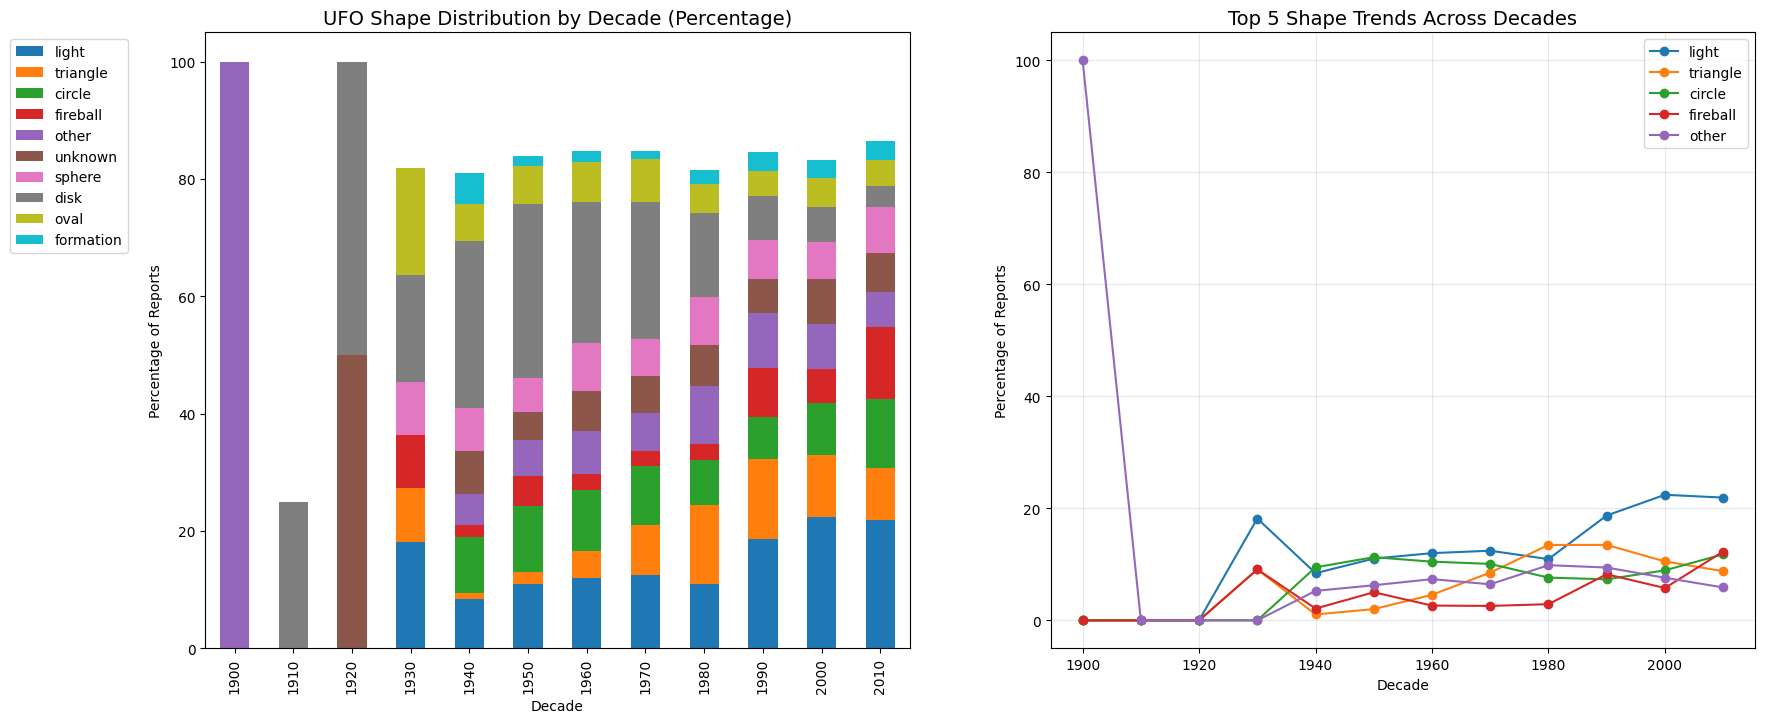

In [67]:
# Get top shapes for focused analysis
top_n_shapes = 10
top_shapes = joined_temporal['shape'].value_counts().head(top_n_shapes).index.tolist()

# Create decade distribution
decade_shape = joined_temporal.groupby(['decade', 'shape']).size().unstack(fill_value=0)
decade_shape_pct = decade_shape.div(decade_shape.sum(axis=1), axis=0) * 100

# Visualize decade trends
fig, axes = plt.subplots(1,2, figsize=(20, 8))

# Plot 1: Percentage distribution over decades
decade_shape_pct[top_shapes].plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('UFO Shape Distribution by Decade (Percentage)', fontsize=14)
axes[0].set_xlabel('Decade')
axes[0].set_ylabel('Percentage of Reports')
axes[0].legend(bbox_to_anchor=(-0.1, 1))

# Plot 2: Line plot showing trends for each shape
for shape in top_shapes[:5]:  # Top 5 for clarity
    axes[1].plot(decade_shape_pct.index, decade_shape_pct[shape], marker='o', label=shape)
axes[1].set_title('Top 5 Shape Trends Across Decades', fontsize=14)
axes[1].set_xlabel('Decade')
axes[1].set_ylabel('Percentage of Reports')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.show()

The decade-level distribution of UFO shapes reveals a clear evolution in how sightings are described over time. Early decades are dominated almost entirely by broad or ambiguous categories such as other or unknown. As reporting volume grew and descriptions became more detailed, the distribution diversified, with shapes such as light, triangle, circle, and fireball emerging more frequently.

Disks are the most common shape reported before 1980s, which aligns with early movies and animations which depict UFO and aliens from a disk-shape aircraft. Starting in the 1990s, light becomes the most common shape and continues to rise into the 2000s.

The trend lines for the top shapes show that while each category grows as total reporting increases, their relative proportions shift meaningfully. Similar to results drawn from the visualization on the left, triangle sightings become less common, while fireball and light reports become more common in recent decades.

### 3.4.2 Seasonal UFO Shape Distributions

<Figure size 1200x800 with 0 Axes>

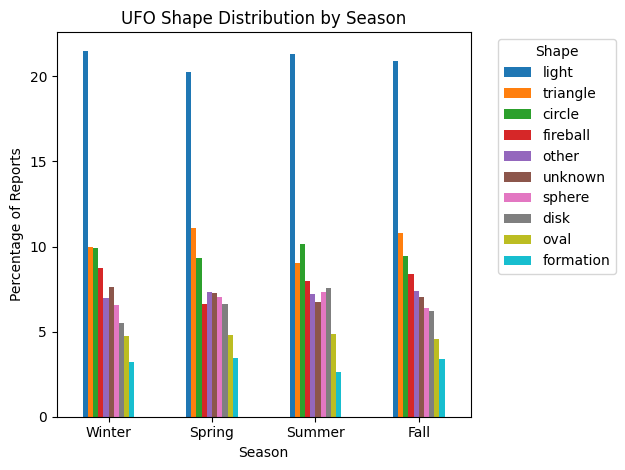

In [68]:
# Create seasonal distribution
season_shape = joined_temporal.groupby(['season', 'shape']).size().unstack(fill_value=0)

# Normalize for percentages
season_shape_pct = season_shape.div(season_shape.sum(axis=1), axis=0) * 100

# Plot seasonal distribution
plt.figure(figsize=(12, 8))
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
season_shape_pct.reindex(season_order)[top_shapes].plot(kind='bar')
plt.title('UFO Shape Distribution by Season')
plt.xlabel('Season')
plt.ylabel('Percentage of Reports')
plt.legend(title='Shape', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

Examining UFO shape distribution across the four seasons reveals that the relative proportions of the major shapes remain remarkably stable throughout the year. Light-based sightings consistently dominate each season, while triangle, circle, fireball, and other shapes maintain nearly identical percentages in winter, spring, summer, and fall.

This uniformity suggests that seasonal factors do not meaningfully influence how observers describe UFO shapes. The shape patterns seem to reflect consistent perceptual tendencies rather than seasonal differences in visibility or atmospheric conditions.

### 3.4.3 Time-of-Day Patterns for Shapes

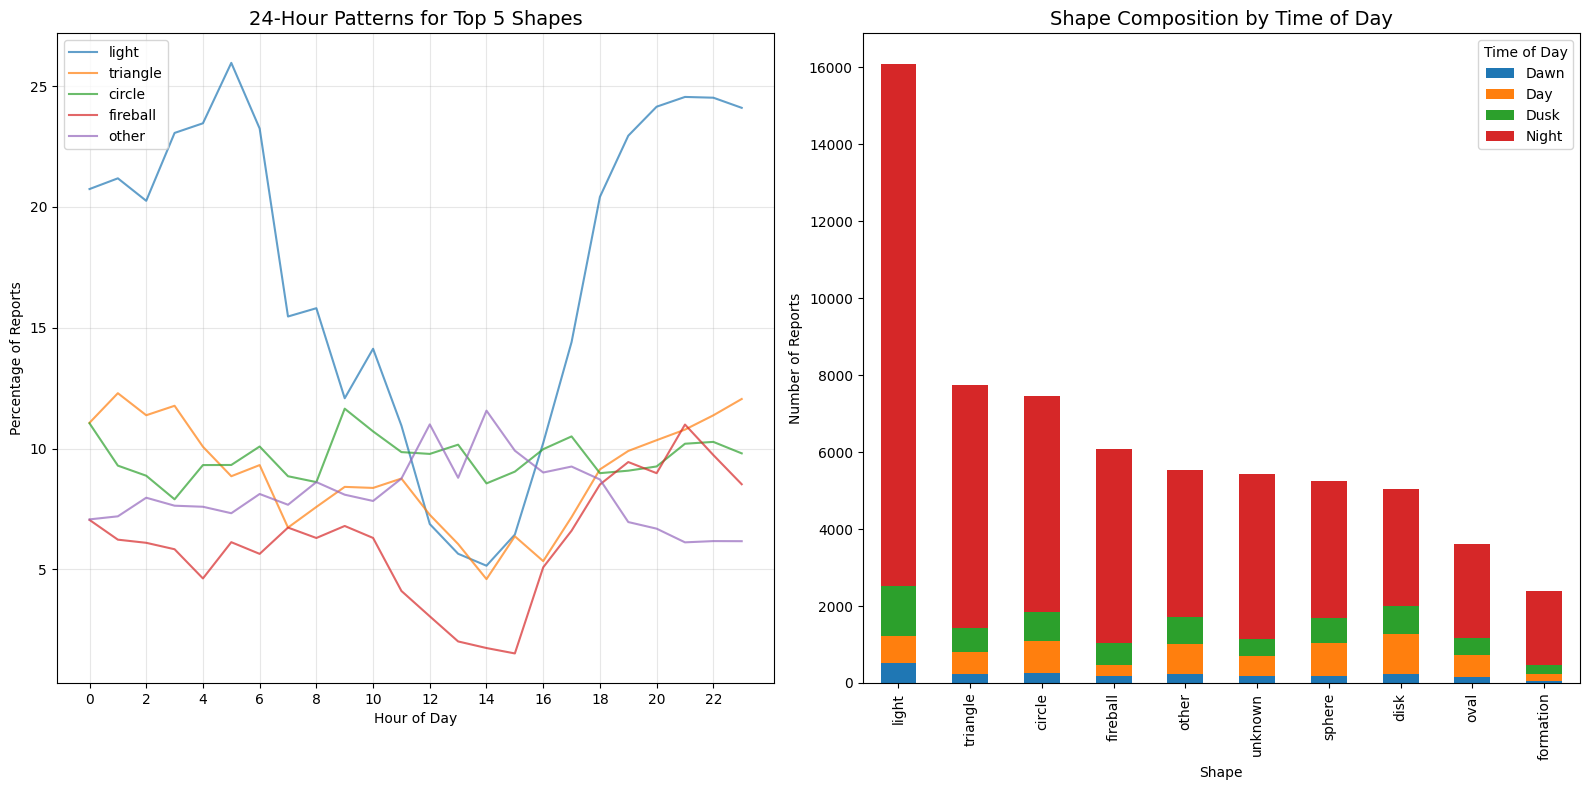

In [69]:
# Create time of day distributions
tod_shape = joined_temporal.groupby(['time_of_day', 'shape']).size().unstack(fill_value=0)
hour_shape = joined_temporal.groupby(['hour', 'shape']).size().unstack(fill_value=0)

# Normalize
tod_shape_pct = tod_shape.div(tod_shape.sum(axis=1), axis=0) * 100
hour_shape_pct = hour_shape.div(hour_shape.sum(axis=1), axis=0) * 100

tod_order = ['Dawn', 'Day', 'Dusk', 'Night']
# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot: 24-hour pattern for top shapes
for shape in top_shapes[:5]:
    axes[0].plot(hour_shape_pct.index, hour_shape_pct[shape], label=shape, alpha=0.7)
axes[0].set_title('24-Hour Patterns for Top 5 Shapes', fontsize=14)
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Percentage of Reports')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(0, 24, 2))

# Plot: Stacked area chart for time of day
tod_counts = tod_shape.reindex(tod_order)[top_shapes]
tod_counts.T.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Shape Composition by Time of Day', fontsize=14)
axes[1].set_xlabel('Shape')
axes[1].set_ylabel('Number of Reports')
axes[1].legend(title='Time of Day')

plt.tight_layout()
plt.show()

The 24-hour pattern for the top five UFO shapes reveals a strong time-of-day effect. Reports consistently dip to their lowest levels in the early afternoon, regardless of shape type. This midday decline is likely because brighter daylight makes subtle lights harder to notice.

In contrast, the stacked bar chart shows that nighttime overwhelmingly dominates sighting activity for every shape category. Lights, triangles, circles, fireballs, and miscellaneous shapes all exhibit the same pattern: night contributes the largest share of reports, followed by dusk, then dawn, with daytime producing the fewest sightings. This suggests that in low-light environments, artificial lights, reflections, and atmospheric effects become more noticeable and are more easily misinterpreted as anomalous phenomena.

Taken together, these visualizations indicate that shape does not dictate when sightings occur, but time of day does.

## 3.5 Duration Analysis vs Shape

In [70]:
def prepare_duration_data(df):
    """Clean and prepare duration data for analysis"""
    df = df.copy()
    df['duration_seconds'] = df['duration (seconds)']
    # Cap at reasonable maximum (1 week = 604800 seconds)
    df.loc[df['duration_seconds'] > 604800, 'duration_seconds'] = 604800

    # Add useful transformations
    df['duration_minutes'] = df['duration_seconds'] / 60
    df['duration_hours'] = df['duration_seconds'] / 3600
    df['log_duration'] = np.log10(df['duration_seconds'] + 1)

    return df

# Prepare a data copy for EDA
duration_df = prepare_duration_data(joined)

- Deleted duration log transform

/tmp/ipython-input-2208886089.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




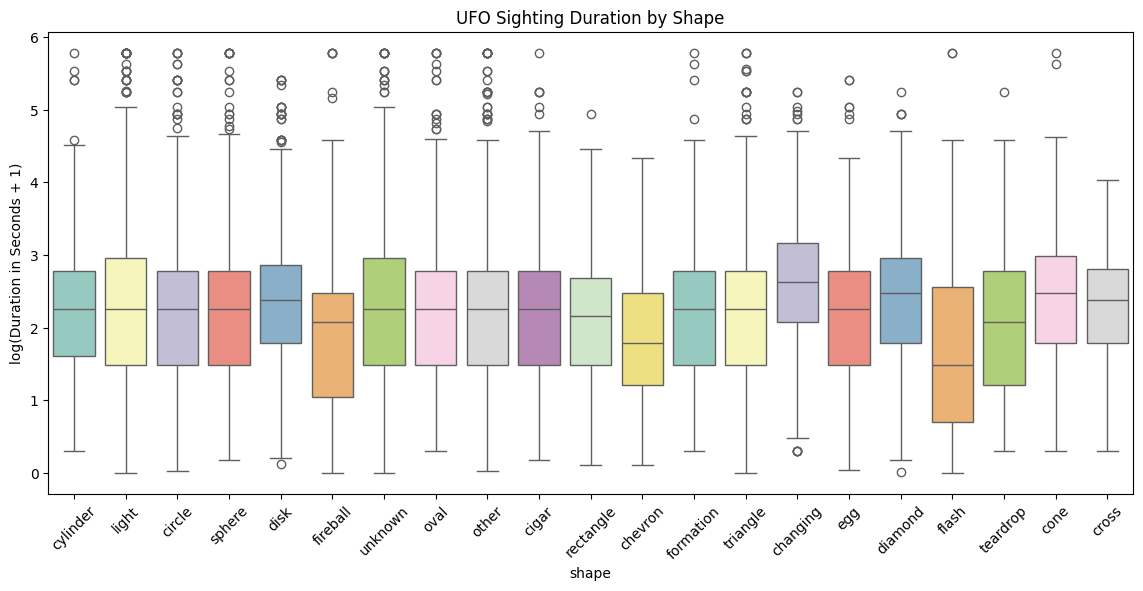

In [71]:
plt.figure(figsize=(14,6))
sns.boxplot(
    data=duration_df,
    x="shape",
    y="log_duration",
    palette="Set3"
)
plt.xticks(rotation=45)
plt.ylabel("log(Duration in Seconds + 1)")
plt.title("UFO Sighting Duration by Shape")
plt.show()


The boxplot comparing log-transformed sighting durations across shapes shows that most shapes share broadly similar duration patterns, with medians clustered around log10 values of roughly 2 to 2.5 (about 100 to 300 seconds). This suggests that, for the majority of sightings, shape does not strongly dictate how long an event lasts. However, shapes like flash tend to show shorter median durations.

All shapes include a substantial number of long-duration outliers, reflecting rare cases where observers report events lasting many minutes or more. These outliers appear across almost every shape category, which reinforces the idea that duration is influenced more by situational factors (visibility, observer attention, event complexity) than by the specific geometry reported.

In [72]:
shape_duration = (duration_df.groupby("shape")["duration_seconds"].mean().reset_index().sort_values("duration_seconds", ascending=False))

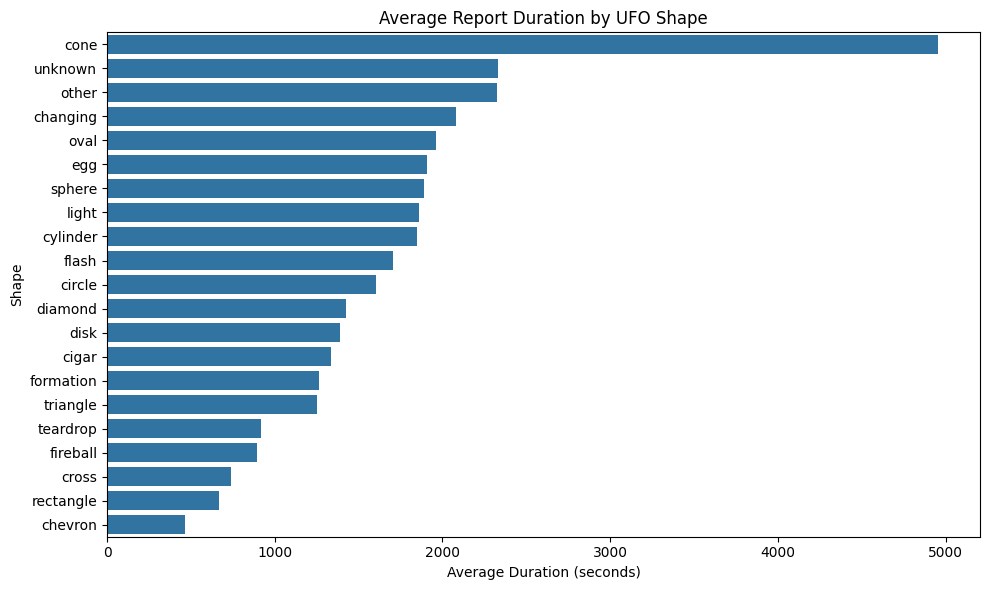

In [73]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=shape_duration,
    x="duration_seconds",
    y="shape",
)

plt.title("Average Report Duration by UFO Shape")
plt.xlabel("Average Duration (seconds)")
plt.ylabel("Shape")
plt.tight_layout()
plt.show()


Showing the same result as in the box plot: cone, unknown, other, and changing shapes tend to be reported with much longer durations, while shapes like chevron, rectangle, cross, fireball, and triangle tend to have shorter sightings.

## 3.6 Education-Level Influence

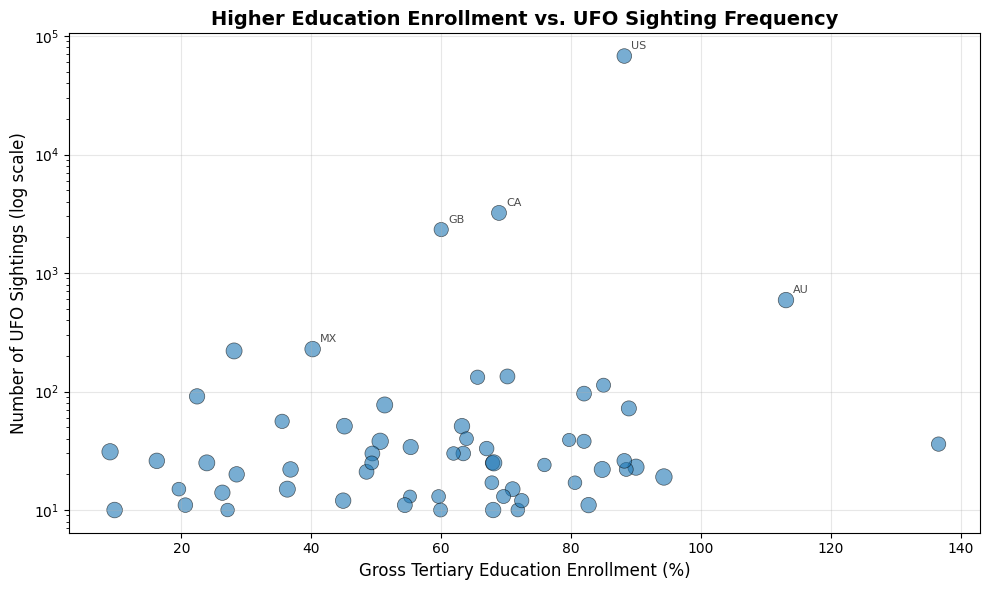

In [74]:
import matplotlib.pyplot as plt
import numpy as np

country_education = joined.groupby('country').agg({
    'shape': 'count',  # Total sightings
    'Gross_Tertiary_Education_Enrollment': 'first',
    'Unemployment_Rate': 'first',
    'population': 'mean',
    'viirs_annual_ave': 'mean'
}).rename(columns={'shape': 'sighting_count'}).reset_index()

# Remove countries with very few sightings
country_education = country_education[country_education['sighting_count'] >= 10]

# Calculate sightings per capita (using mean city population as proxy)
country_education['sightings_per_capita'] = (
    country_education['sighting_count'] / country_education['population']
)

# Filter rows with valid values
df_edu = country_education.dropna(
    subset=["Gross_Tertiary_Education_Enrollment"]
).copy()

# Compute marker sizes using population
marker_sizes = np.log10(df_edu["population"] + 1) * 20

# Create single plot
plt.figure(figsize=(10, 6))

sc = plt.scatter(
    df_edu["Gross_Tertiary_Education_Enrollment"],
    df_edu["sighting_count"],
    s=marker_sizes,
    alpha=0.6,
    edgecolors="black",
    linewidth=0.5
)

# Labels + Title
plt.title(
    "Higher Education Enrollment vs. UFO Sighting Frequency",
    fontsize=14,
    fontweight="bold"
)
plt.xlabel("Gross Tertiary Education Enrollment (%)", fontsize=12)
plt.ylabel("Number of UFO Sightings (log scale)", fontsize=12)
plt.yscale("log")
plt.grid(True, alpha=0.3)

top_countries = df_edu.nlargest(5, "sighting_count")

for _, row in top_countries.iterrows():
    plt.annotate(
        row["country"].upper(),
        (row["Gross_Tertiary_Education_Enrollment"], row["sighting_count"]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=8,
        alpha=0.7
    )
plt.tight_layout()
plt.show()


Most countries cluster at relatively low sighting counts regardless of their education enrollment percentage, indicating that expanded access to higher education does not meaningfully increase or decrease UFO reporting behavior.

Instead, a small set of outliers—most notably the US, Canada, Great Britain, and Australia—drive the appearance of a trend. These countries report far more sightings than others with relatively high education levels among all countries in the dataset. The presence of these outliers suggests that education play a role in shaping sighting frequency.

## 3.7 Correlation Matrices

In [75]:
numeric_features = [
    "latitude",
    "longitude",
    "duration (seconds)",
    #city-level features
    "population",
    "avg_annual_temp(°C)",
    "temp_seasonality",
    "annual_precipitation(mm)",
    "elevation(m)",
    "viirs_annual_ave",
    #country-level features
    "Gross_Tertiary_Education_Enrollment",
    "Unemployment_Rate",
    #newly-created features
    "dist_to_nearest_airport(m)",
]

categorical_features = ["time_of_day"]
target=["shape"]

We create model_df including all cleaned numerical features,categorical features, and the target label into a single dataset that is for encoding, correlation analysis, and machine learning modeling.

In [76]:
X = joined[numeric_features + categorical_features]
y = joined["shape"]

In [77]:
model_df = pd.concat([X, y], axis=1).dropna(subset=numeric_features+ categorical_features + ["shape"])
model_df

,latitude,longitude,duration (seconds),population,avg_annual_temp(°C),temp_seasonality,annual_precipitation(mm),elevation(m),viirs_annual_ave,Gross_Tertiary_Education_Enrollment,Unemployment_Rate,dist_to_nearest_airport(m),time_of_day,shape
0,29.883056,-97.941111,2700.0,74469.0,20.008333,706.189636,879.0,179.0,35.295166,88.2,14.70,780.873079,Night,cylinder
1,29.384210,-98.581082,7200.0,2069843.0,20.741667,673.089294,790.0,222.0,45.640274,88.2,14.70,2.060551,Night,light
2,53.200000,-2.916667,20.0,87507.0,9.645833,447.607056,691.0,21.0,0.000000,60.0,3.85,7217.481990,Dusk,circle
3,28.978333,-96.645833,20.0,66523.0,21.533333,614.785034,958.0,35.0,42.157391,88.2,14.70,1126.489912,Night,circle
4,21.418056,-157.803611,900.0,35945.0,23.845833,138.899246,2606.0,31.0,10.316186,88.2,14.70,5179.789007,Night,light
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76436,36.165833,-86.784444,600.0,1178679.0,15.220833,863.108704,1254.0,132.0,77.557053,88.2,14.70,1955.936400,Night,light
76437,43.613611,-116.202500,1200.0,449428.0,10.808333,855.434021,321.0,840.0,18.624582,88.2,14.70,1168.251147,Night,circle
76438,38.297222,-122.284444,1200.0,81643.0,15.312500,480.937195,681.0,13.0,14.898866,88.2,14.70,2122.386753,Night,other
76439,38.901111,-77.265556,5.0,16369.0,13.150000,876.047424,1040.0,122.0,15.233685,88.2,14.70,2715.740698,Night,circle


### One-Hot Encoding

In [78]:
model_df_encoded = pd.get_dummies(model_df, columns=categorical_features+target, drop_first=True)

In [79]:
model_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76441 entries, 0 to 76440
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   latitude                             76441 non-null  float64
 1   longitude                            76441 non-null  float64
 2   duration (seconds)                   76441 non-null  float64
 3   population                           76441 non-null  float64
 4   avg_annual_temp(°C)                  76441 non-null  float64
 5   temp_seasonality                     76441 non-null  float64
 6   annual_precipitation(mm)             76441 non-null  float64
 7   elevation(m)                         76441 non-null  float64
 8   viirs_annual_ave                     76441 non-null  float64
 9   Gross_Tertiary_Education_Enrollment  76441 non-null  float64
 10  Unemployment_Rate                    76441 non-null  float64
 11  dist_to_nearest_airport(m)  

In [80]:
X_encoded = model_df_encoded.drop(columns=[col for col in model_df_encoded.columns if col.startswith('shape_')]).astype(int)
y_encoded = model_df_encoded[[col for col in model_df_encoded.columns if col.startswith('shape_')]].astype(int)

### Feature Correlation Matrix

In [81]:
corr = X_encoded.corr().round(2)

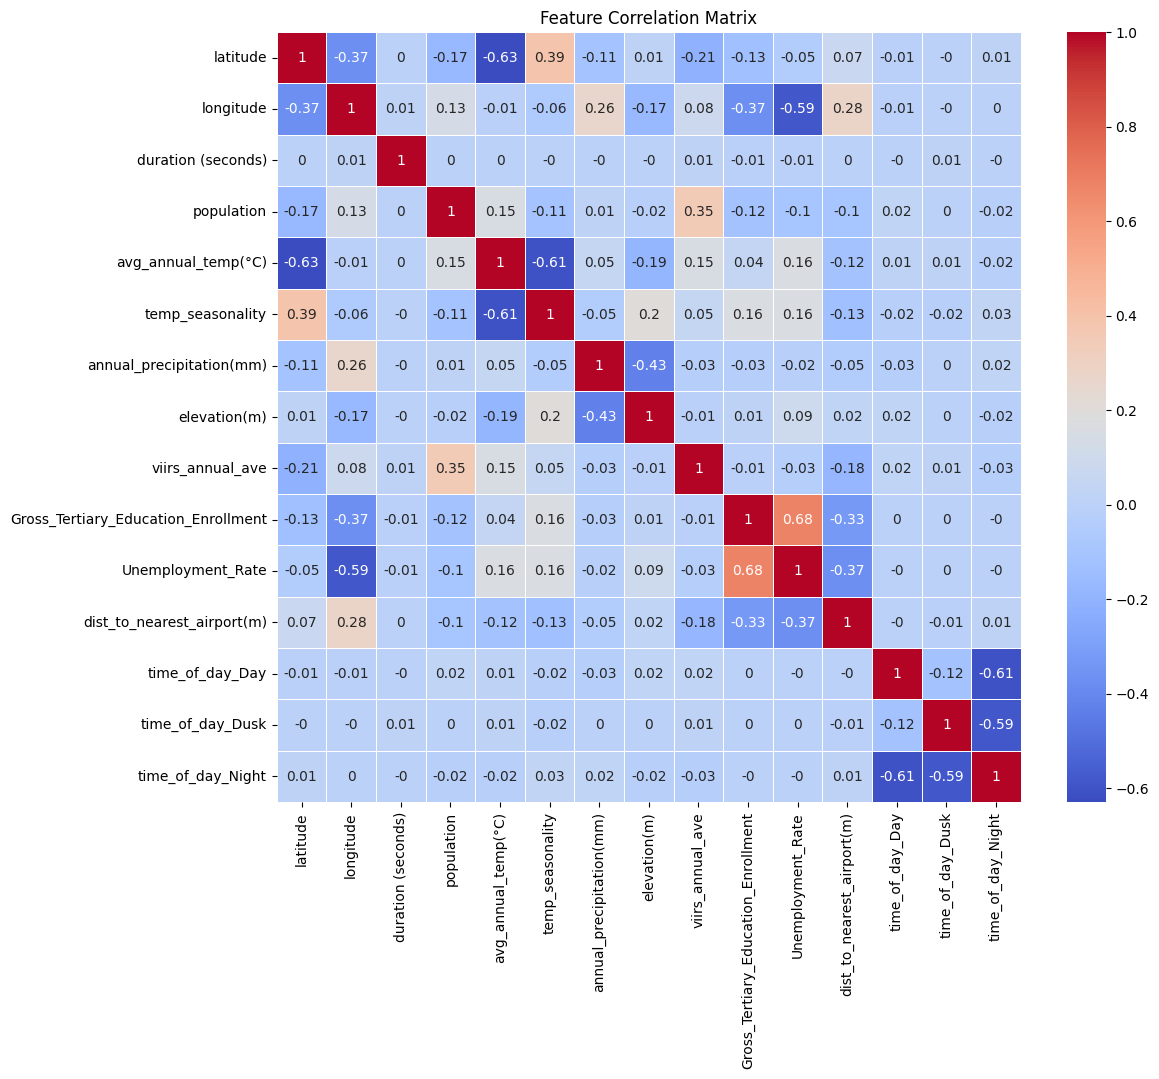

In [82]:
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

(simple analysis)

### Feature Target Correlation Matrix

In [83]:
# Compute correlation between each feature and each shape target column
corr_xy = X_encoded.apply(lambda col: y_encoded.corrwith(col)).round(2)

# Make it a DataFrame for heatmap layout
corr_xy_df = corr_xy

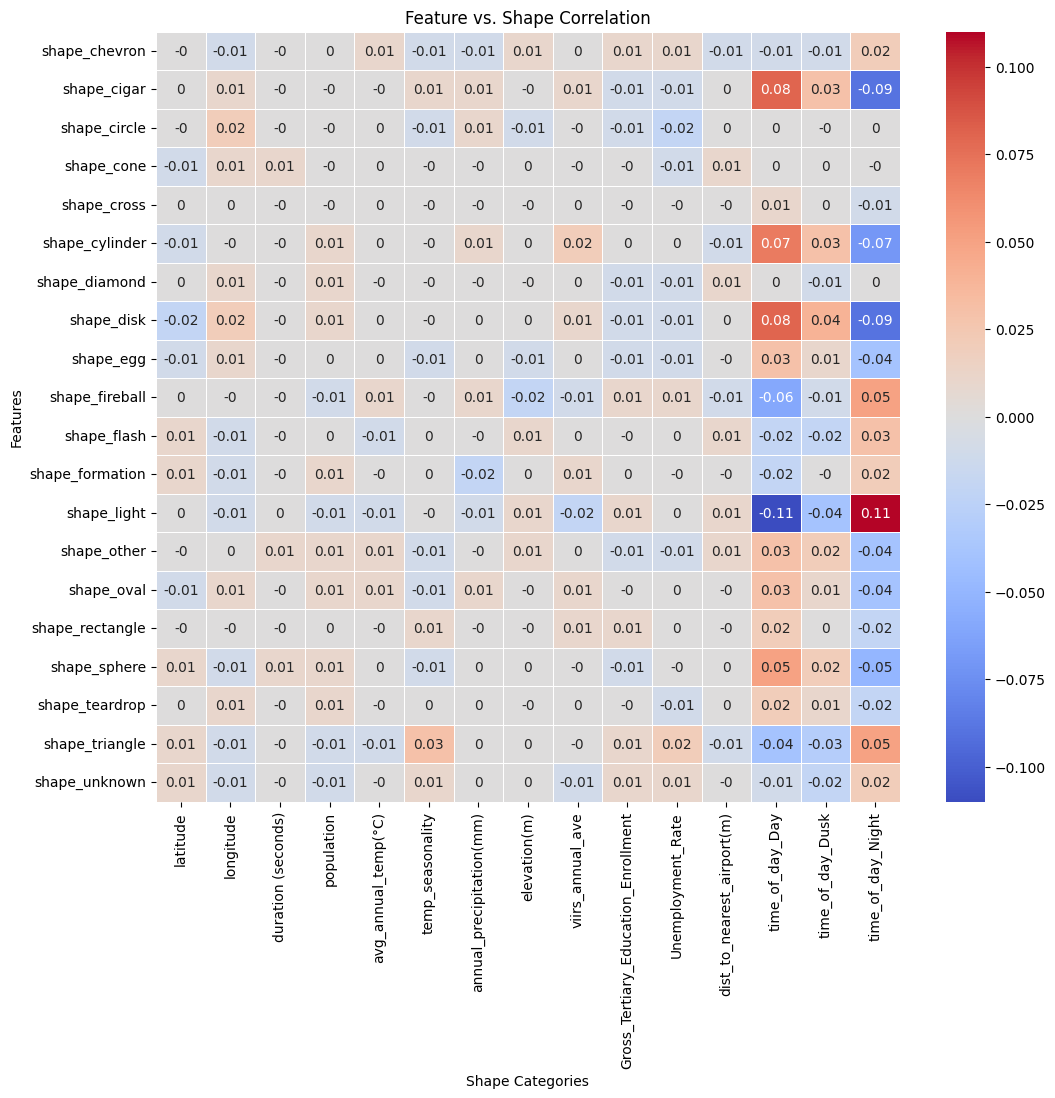

In [84]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_xy_df, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Feature vs. Shape Correlation")
plt.xlabel("Shape Categories")
plt.ylabel("Features")
plt.show()

## Part 4: Feature Engineering and Processing

### Train & Test Set Preparation

SMOTE requires a single categorical label column, so we convert y to single column for resampling.

In [85]:
y_single = y_encoded.idxmax(axis=1)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y_single,
    test_size=0.2,
    random_state=42,
    stratify=y_single
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 61152
Test size: 15289


#### SMOTE-Based Oversampling for Class Imbalance

In [87]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

After balancing the training data, we apply One-Hot encoding again to both training and test targets for multi-class classification compatibility.

In [88]:
encoder = OneHotEncoder(sparse_output=False)
y_train_resampled_encoded = encoder.fit_transform(y_train_resampled.to_numpy().reshape(-1,1))
y_test_encoded = encoder.transform(y_test.to_numpy().reshape(-1,1))

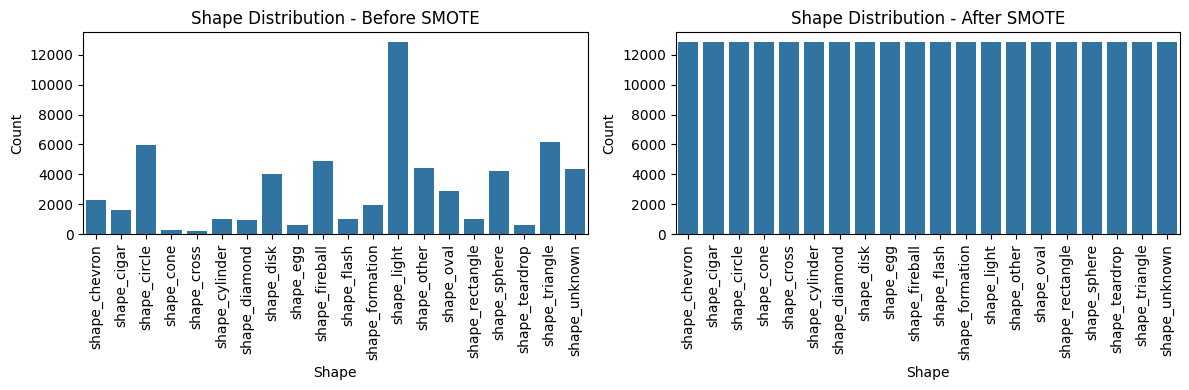

In [89]:
shape_counts_before = y_train.value_counts().sort_index()
shape_counts_after = y_train_resampled.value_counts().sort_index()

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.barplot(x=shape_counts_before.index, y=shape_counts_before.values)
plt.title("Shape Distribution - Before SMOTE")
plt.xlabel("Shape")
plt.ylabel("Count")
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.barplot(x=shape_counts_after.index, y=shape_counts_after.values)
plt.title("Shape Distribution - After SMOTE")
plt.xlabel("Shape")
plt.ylabel("Count")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


#### Train/Test Dataset Preparation Summary

## Train/Test Dataset Summary

| Name | Description | Used For |
|------|-------------|----------|
| `X` | Raw numeric + categorical features for modeling | /|
| `y` | Raw `shape` column | / |
| `model_df` | `X` + `y`| / |
| `X_encoded` | Numeric features + One-hot encoded categorical features| / |
| `y_encoded` | One-hot encoded `shape` | / |
| `model_df_encoded` |`X_encoded`+ `y_encoded`| /|
| `y_single` | Target converted to single numeric labels (required by SMOTE) | SMOTE balancing |
| `X_train`, `X_test` | Original unbalanced dataset after train/test split | Baseline + SMOTE input |
| `y_train`, `y_test` | Original target labels after split | Baseline + SMOTE input |
| `X_train_resampled` | Balanced features after SMOTE | Model training |
| `y_train_resampled` | Balanced target after SMOTE (single label) | /|
| `y_train_resampled_encoded` | Balanced one-hot encoded training labels after SMOTE | Model training |
| `X_test` | One-hot encoded test labels | Model evaluation |
| `y_test_encoded` | One-hot encoded test labels | Model evaluation |



## Part 5 Baseline Modeling

In this section, we will build 2 baseline models for our UFO sightings shape prediction.

## 5.1 Majority Class Classifier

The first baseline model is a simple majority class classifier. This is a very trivial model that always predict the most common type in our shape class. This model requires no features and no learning, but its accuracy can be surprisingly high when the dataset is highly imbalanced, which is exactly the case for the UFO sighting dataset.

Here's some basic information of our target class.

In [90]:
print("Number of samples after filtering:", len(X_train))
print("Number of classes:", y_train.nunique())
print("Class distribution:")
print(y_train.value_counts(normalize=True).round(3))

Number of samples after filtering: 61152
Number of classes: 20
Class distribution:
shape_light        0.210
shape_triangle     0.101
shape_circle       0.097
shape_fireball     0.080
shape_other        0.072
shape_unknown      0.071
shape_sphere       0.069
shape_disk         0.066
shape_oval         0.047
shape_chevron      0.037
shape_formation    0.031
shape_cigar        0.026
shape_flash        0.017
shape_rectangle    0.017
shape_cylinder     0.016
shape_diamond      0.015
shape_egg          0.010
shape_teardrop     0.010
shape_cone         0.004
shape_cross        0.003
Name: proportion, dtype: float64


In [91]:
print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 61152
Test size: 15289


For a majority-class model, it always predict the most frequent shape in our training dataset (i.e. the majority class). So now we will figure out what this shape is.

In [92]:
majority_class = y_train.value_counts().idxmax()
print("\nMajority class in training data:", majority_class)


Majority class in training data: shape_light


Now we can make our prediction.

In [93]:
y_pred_majority = np.full_like(y_test, fill_value=majority_class)
majority_acc = accuracy_score(y_test, y_pred_majority)
print("Majority-class baseline accuracy on test set: {:.4f}".format(majority_acc))

Majority-class baseline accuracy on test set: 0.2103


**Interpretation**

This baseline acts as the absolute minimum standard.
Any model that performs worse than this is essentially worthless.

## 5.2 Multinomial Logistic Regression

The second baseline model is the multinormal logistic regression model. It is simple, interpretable, and suitable for our task.
We can use it to test whether our features have linear separability with respect to UFO shapes.

This baseline model defines a higher baseline: this is a very simple model and subsequent models should have better performance than it.

### 5.2.1 Preprocessing

To fit a multinormal logistic regression, we will standardize all the numeric features to ensure equal weighting.

In [94]:
scaler = StandardScaler()
X_train_scaled  = scaler.fit_transform(X_train[numeric_features])
X_test_scaled  = scaler.transform(X_test[numeric_features])
X_train_resampled_scaled  = scaler.fit_transform(X_train_resampled[numeric_features])
print("Scaled training feature shape:", X_train_scaled.shape)
print("Scaled test feature shape:", X_test_scaled.shape)

Scaled training feature shape: (61152, 12)
Scaled test feature shape: (15289, 12)


After preprocessing, we horizontally concatenated the standardized numeric matrix and the one-hot encoded categorical matrix using np.hstack, obtaining a fully numeric feature matrix suitable for multinomial logistic regression.

### 5.2.2 Training

In [95]:
# Multinomial Logistic Regression Model
log_reg = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1000
)

In [96]:
log_reg.fit(X_train_scaled, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.



LogisticRegression(max_iter=1000, multi_class='multinomial')

In [97]:
# Predictions
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# Evaluation
multi_log_train_acc = accuracy_score(y_train, y_train_pred)
multi_log_test_acc = accuracy_score(y_test, y_test_pred)

In [98]:
print("Logistic Regression (multinomial) performance:")
print("  Train accuracy: {:.4f}".format(multi_log_train_acc))
print("  Test accuracy:  {:.4f}".format(multi_log_test_acc))
print("Majority baseline accuracy: {:.4f}".format(majority_acc))

Logistic Regression (multinomial) performance:
  Train accuracy: 0.2103
  Test accuracy:  0.2103
Majority baseline accuracy: 0.2103


Notice that the train/test accuracy of our multinormal logistic regression model is almost the same as our majority baseline accuray. We can further check the underlying reason.

In [99]:
pd.Series(y_test_pred).value_counts()

,count
shape_light,15281
shape_other,4
shape_circle,3
shape_sphere,1


**Interpretation**

Out of all test predictions, almost all test cases are assigned with label light. This extreme imbalance indicates that the multinormal logistic regression model defaults to predicting the dominant class in nearly every situation, which make it highly similar to the majority class classifier.

Such behavior is typical when the features provide little linear separation among classes or when the classifier is strongly influenced by the underlying class imbalance in the training data. This suggests the decision boundaries are nonlinear, and more expressive models are necessary.

## 5.3 Analysis

We can now sum up what we have learned from our baseline models:

**1. Linear models are insufficient**

Even with the new categorical variable encoded, logistic regression performs similarly to the majority-class model.

This means the shape categories cannot be separated using simple linear hyperplanes.

**2. Underlying relationships among features are highly nonlinear**

UFO shape perception may depend on complex interactions among different features. Linear models cannot capture such complex relationships.

**3. Next Models to Try**

For our next step, we will explore some other models:

* Random Forests（nonlinear splits, handles interactions）

* AdaBoost / XGBoost（handle imbalanced dataset and learn nonlinear boundaries）

* SVM（nonlinear boundaries）

These models are specifically suited for nonlinear feature datasets like ours.

## Part 6 Modeling Pt.2



In this section we move beyond simple linear baselines and build more complicated models that can capture nonlinear relationships between our features and the targeted UFO shape:


1. **Random Forests**: nonlinear splits, naturally capture feature interactions.
2. **AdaBoost / XGBoost**: boosting methods that handle nonlinear boundaries and can deal with imbalanced data via weighting.
3. **Support Vector Machines (SVMs)**: nonlinear decision boundaries via kernels.

For all of them, we will consider the class imbalance problem.

We will compare their performance to previous baselines in terms of accuracy and macro F1.


First we will build an evaluation function that will be applied to all models.

In [100]:
def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")

    print(f"=== {name} ===")
    print(f"Accuracy    : {acc:.3f}")
    print(f"Macro F1    : {macro_f1:.3f}")
    print(f"Weighted F1 : {weighted_f1:.3f}")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred))

    return {
        "model": name,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
    }

### 6.1 Handling Class Imbalance


Our target labels (UFO shapes) are strongly imbalanced. In the data-processing section we already created two versions of the training data:

* the original imbalanced training set (`X_train, y_train`)
* a SMOTE-resampled training set (`X_train_resampled, y_train_resampled`) where minority classes are upsampled.

In this modeling section, we compare two strategies:

1. **No SMOTE (original training data):**  
   - For tree-based models and SVM we use inverse-frequency `class_weight` (or per-sample `sample_weight` for boosting) to perform cost-sensitive learning.

2. **With SMOTE (balanced training data):**  
   - We train the same models on `X_train_resampled, y_train_resampled` without additional class weights, and always evaluate on the original, imbalanced test set.

For all runs we report both accuracy and macro F1. Accuracy tells us how well the model performs overall, while macro F1 gives equal importance to each class and is therefore more informative about how well we are doing on rare UFO shapes.

### 6.2 Random Forest

Random Forests build an ensemble of decision trees, each trained on a bootstrap sample of the data and a random subset of features. The final prediction is made by majority vote.

Key properties:



* **Nonlinear splits**: each tree splits the feature space using axis-aligned thresholds, creating highly nonlinear decision regions.
* **Feature interactions**: trees naturally capture interactions between features by splitting on different variables along a path.
* **Robustness**: averaging over many trees reduces variance and improves stability.

To handle class imbalance we can set `class_weight="balanced"`, which makes mistakes on rare shapes more expensive. This encourages the forest to carve out regions in feature space for minority classes instead of collapsing to the majority shape.

We evaluate the model on both training and test sets using accuracy and macro F1, and compare it to the baselines from the previous section.

In [101]:
def run_rf(Xtr, ytr, Xte, yte, name, use_class_weight=False):
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=42,
        class_weight="balanced" if use_class_weight else None
    )
    rf.fit(Xtr, ytr)
    ytr_pred = rf.predict(Xtr)
    yte_pred = rf.predict(Xte)
    evaluate_model(name + " - train", ytr, ytr_pred)
    evaluate_model(name + " - test", yte, yte_pred)

In [102]:
# Original dataset + class_weight='balanced'
run_rf(X_train, y_train, X_test, y_test,
       "Random Forest (orig, class_weight='balanced')",
       use_class_weight=True)

KeyboardInterrupt: 

In [ ]:
# SMOTE
run_rf(X_train_resampled, y_train_resampled, X_test, y_test,
       "Random Forest (SMOTE, no class_weight)",
       use_class_weight=False)

### 6.3 AdaBoost
AdaBoost is a boosting method: it builds a sequence of weak learners (here, shallow decision trees), where each new learner focuses on the mistakes of the previous ones.

Key properties:

* **Nonlinear boundaries**: even though each tree is shallow, the ensemble as a whole produces complex, nonlinear decision boundaries.
* **Imbalance handling via weights**: AdaBoost supports a `sample_weight` argument. We pass per-example weights derived from class weights, so that misclassifying rare shapes is penalized more during training.
* **Focus on hard examples**: boosting naturally upweights examples that are repeatedly misclassified, which often helps with minority classes.

We keep the trees shallow (`max_depth=2`) so that each weak learner is simple, and let the ensemble build a rich nonlinear model.

In [ ]:
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight="balanced", classes=classes, y=y_train
)
class_weight_dict = dict(zip(classes, class_weights))
sample_weight_train = np.array([class_weight_dict[c] for c in y_train])

In [ ]:
ada_base = DecisionTreeClassifier(max_depth=2, random_state=42)

# Original dataset + sample_weight
ada_orig = AdaBoostClassifier(
    estimator=ada_base,
    n_estimators=300,
    learning_rate=0.1,
    random_state=42
)
ada_orig.fit(X_train, y_train, sample_weight=sample_weight_train)
evaluate_model("AdaBoost (orig + sample_weight) - train",
               y_train, ada_orig.predict(X_train))
evaluate_model("AdaBoost (orig + sample_weight) - test",
               y_test, ada_orig.predict(X_test))

In [ ]:
# SMOTE
ada_smote = AdaBoostClassifier(
    estimator=ada_base,
    n_estimators=300,
    learning_rate=0.1,
    random_state=42
)
ada_smote.fit(X_train_resampled, y_train_resampled)
evaluate_model("AdaBoost (SMOTE, no sample_weight) - train",
               y_train_resampled, ada_smote.predict(X_train_resampled))
evaluate_model("AdaBoost (SMOTE, no sample_weight) - test",
               y_test, ada_smote.predict(X_test))

### 6.4 XGBoost
XGBoost is a powerful gradient-boosted tree implementation that usually performs very well on structured/tabular data.

Key properties:

* **Nonlinear decision boundaries**: built from many decision trees added sequentially.
* **Imbalance handling**: we convert class weights into `sample_weight` so that the boosting process focuses more on rare shapes.
* **Regularization**: parameters such as `max_depth`, `subsample`, and `colsample_bytree` help control overfitting.

In practice, one extra implementation detail is that XGBoost expects the target labels to be encoded as integer class IDs \(0, 1, \dots, K-1\), rather than arbitrary string labels like `"circle"` or `"triangle"`. To satisfy this requirement without changing the semantics of the task, we first apply a `LabelEncoder` to transform the original UFO shape labels into integers for training. After the model predicts integer class IDs on the test set, we then apply the inverse transformation to map these predictions back to the original string labels before computing accuracy, macro F1, and the classification report. This encoding step is purely a technical convenience for XGBoost and does not affect the underlying evaluation or interpretation of the model.


In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)
y_train_resampled_enc = le.transform(y_train_resampled)

In [ ]:
# Original dataset + sample_weight
xgb_orig = XGBClassifier(
    objective="multi:softprob",
    num_class=len(classes),
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)
xgb_orig.fit(X_train, y_train_enc, sample_weight=sample_weight_train)
y_test_pred_xgb_enc = xgb_orig.predict(X_test)
y_test_pred_xgb = le.inverse_transform(y_test_pred_xgb_enc)
evaluate_model("XGBoost (orig + sample_weight) - train",
               y_train_enc, xgb_orig.predict(X_train))
evaluate_model("XGBoost (orig + sample_weight) - test",
               y_test, y_test_pred_xgb)

In [ ]:
# SMOTE
xgb_smote = XGBClassifier(
    objective="multi:softprob",
    num_class=len(classes),
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)
xgb_smote.fit(X_train_resampled, y_train_resampled_enc)
y_test_pred_xgb_smote_enc = xgb_smote.predict(X_test)
y_test_pred_xgb_smote = le.inverse_transform(y_test_pred_xgb_smote_enc)
evaluate_model("XGBoost (SMOTE, no sample_weight) - train",
               y_train_enc, xgb_smote.predict(X_train))
evaluate_model("XGBoost (SMOTE, no sample_weight) - test",
               y_test, y_test_pred_xgb_smote)

### 6.5 SVM with Nonlinear Kernel

Support Vector Machines (SVMs) aim to find decision boundaries that maximize the margin
between classes. With a nonlinear kernel such as the **RBF kernel**, SVMs can express
complex, curved boundaries in the original feature space.

We use:

* `kernel="rbf"` to obtain nonlinear decision boundaries.
* `C` to control the trade-off between margin size and training errors。
* `gamma="scale"` for a data-dependent kernel width.
* `class_weight="balanced"` to give higher penalty to misclassifications of minority shapes.

This model is particularly focused on **decision boundary geometry**. Unlike Random Forests and boosting, which aggregate many trees, the SVM solution is determined by a subset of the training points (the support vectors), often near class boundaries.

In [ ]:
# Original dataset + class_weight="balanced"
svm_orig = SVC(
    kernel="rbf",
    C=3.0,
    gamma="scale",
    class_weight="balanced",
    random_state=42,
    max_iter = 5000
)
svm_orig.fit(X_train_scaled, y_train)
evaluate_model("SVM (orig, class_weight='balanced') - train",
               y_train, svm_orig.predict(X_train_scaled))
evaluate_model("SVM (orig, class_weight='balanced') - test",
               y_test, svm_orig.predict(X_test_scaled))

In [ ]:
svm_smote = SVC(
    kernel="rbf",
    C=3.0,
    gamma="scale",
    class_weight=None,
    random_state=42,
    max_iter = 5000
)
svm_smote.fit(X_train_resampled_scaled, y_train_resampled)
evaluate_model("SVM (SMOTE, no class_weight) - train",
               y_train_resampled, svm_smote.predict(X_train_resampled_scaled))
evaluate_model("SVM (SMOTE, no class_weight) - test",
               y_test, svm_smote.predict(X_test_scaled))

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



### 6.6 Analysis


#### 6.6.1 Model comparison with and without SMOTE

We evaluate three nonlinear models: Random Forests, AdaBoost, and XGBoost. For all of them, we use two imbalance-handling strategies:


1. **Original imbalanced training data**, using class/sample weights (cost-sensitive learning).
2.  **SMOTE-resampled training data**, without additional weights (data-level balancing).

All models are evaluated on the same original, imbalanced test set.

The majority-class baseline attains **21.0%** accuracy by always predicting the most frequent shape (“light”), and multinomial logistic regression essentially reproduces this baseline, confirming that purely linear decision boundaries cannot exploit our enriched feature set.

---

#### Random Forests

For Random Forests trained on the **original** training data with `class_weight="balanced"`, we obtain:

* **Train:** 69.3% accuracy, macro F1 = 0.661
* **Test:** 10.5% accuracy, macro F1 = 0.077

On the training set, the forest achieves high recall for many minority classes (often above 0.9 for the rare shapes), but this does not generalize. For the test dataset, the accuracy didn't even reach half of the baseline model, and macro F1 is also very low. This shows a sign of overfitting. The model learns a very specific and complicated decision boundary for minority shapes in the training data, but it fails to meet the test dataset.

When we switch to the SMOTE-resampled training set and remove class weights, the Random Forest shows:

* **Train:** 90.3% accuracy, macro F1 = 0.903
* **Test:** 13.3% accuracy, macro F1 = 0.079

It's obvious that SMOTE makes the training problem much easier. Our model reaches a very high score on both accuracy and macro F1.However, test accuracy only improves from 10.5% to 13.3%, and macro F1 is essentially unchanged. In other words, SMOTE + Random Forest slightly improves overall accuracy but **does not actually solve the imbalance problem**. The forest largely memorizes the oversampled training shapes without discovering a generalizable structure.

---

#### AdaBoost

AdaBoost performs poorly in all configurations. With original data + sample weights, we obtain:

* **Train:** 12.2% accuracy, macro F1 = 0.037
* **Test:** 12.6% accuracy, macro F1 = 0.037

Most classes have F1 scores close to zero. To be exact, the model focuses on the relatively frequent shapes and ignores the rest. When we train AdaBoost on the SMOTE-resampled data (with no sample weights), the results are very similar:

* **Train:** 9.0% accuracy, macro F1 = 0.039
* **Test:** 13.9% accuracy, macro F1 = 0.039

Despite the balanced training set, the classifier still predict only a few shapes on both train and test dataset, and there appears to have many classes with 0 prediction. This behavior is consistent with the known sensitivity of AdaBoost to noise and heavy weighting. For our case, with 21 classes and substantial label noise, boosting ends up focusing too much on a small subset of classes and fails to build a useful multi-class decision function. In short, **AdaBoost is not a good fit for this particular problem**.

---

#### XGBoost

XGBoost, as a stronger gradient-boosted tree model, behaves differently. On the original training data with sample weights derived from inverse class frequencies, XGBoost achieves:

* **Train:** 28.0% accuracy, macro F1 = 0.284
* **Test:** 7.3% accuracy, macro F1 = 0.061

This is again far below the majority baseline and indicates that aggressive cost-sensitive weighting alone is not sufficient: the model sacrifices overall accuracy but didn't improve much for macro F1.

When we train XGBoost on the SMOTE-resampled data (with no sample weights), performance improves:

* **Train:** 31.2% accuracy, macro F1 = 0.258
* **Test:** 16.2% accuracy, macro F1 = 0.066

Accuracy increases compared to the original version and comes closer to the 21% majority baseline, while macro F1 remains higher than the baseline. We see that the SMOTE-trained model does a better job on the dominant “light” class and predicts a non-trivial fraction of several minority shapes, but in general, the performance on rare classes is still weak. The model clearly benefits from the balanced training distribution, yet **the task itself is too complex that this benefit is limited**.

#### 6.6.2 Overall discussion: imbalance strategies and model capacity

Across all nonlinear models, two main conclusions emerge:

1. **In general, nonlinear models do not beat the majority baseline.**
   Even powerful tree ensembles like Random Forests and XGBoost achieve test accuracies well below the 21% majority-class baseline, no matter if we trained with aggressive class or sample weights. This indicates that forcing the models to treat all classes equally during training (either via large weights or synthetic oversampling) can actually easily lead to overfitting and degraded generalization.

2. **SMOTE can help improve result, but is not enough as a fix.**

   * For Random Forests, SMOTE largely improves training performance but only slightly improves test accuracy and macro F1.
   * AdaBoost performs poorly under both strategies, essentially collapsing to a few classes.
   * For XGBoost, SMOTE clearly helps compared to sample weighting, but still does not reach the majority baseline.

These results suggest that **the underlying prediction task is inherently hard**: UFO shapes are noisy, high-cardinality labels, and our available features only weakly constrain which shape is reported. In this setting, sophisticated imbalance handling can easily push models into unstable regimes without delivering large gains on rare classes.

From a modeling perspective, the experiments are still informative:

* They show that **linear baselines (majority, logistic regression)** set a surprisingly strong bar that our more complex models cannot easily surpass on this dataset.
* They highlight the limitations of both **data-level resampling (SMOTE)** and **model-level reweighting (class/sample weights)** in a highly imbalanced, noisy, multi-class problem.
* They motivate a more conservative conclusion: rather than trying to perfectly predict every shape, a more realistic goal may be to capture broad patterns (e.g., “light-like” vs. “solid object” shapes) or to model shape distributions conditional on context, acknowledging that fine-grained, 21-way classification is extremely challenging with the available information.
